In [ ]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'26Feb2021 11:10'

In [ ]:
!python --version

Python 3.7.9


In [ ]:
# Development version in GitHub
!pip install --upgrade "git+https://github.com/lisphilar/covid19-sir.git#egg=covsirphy"
# Stable version in PyPI
# !pip install --upgrade covsirphy

  Cloning https://github.com/lisphilar/covid19-sir.git to /tmp/pip-install-7651m2sw/covsirphy_346b0ba074ff46c4afbf0cdb29a975f7
  Running command git clone -q https://github.com/lisphilar/covid19-sir.git /tmp/pip-install-7651m2sw/covsirphy_346b0ba074ff46c4afbf0cdb29a975f7
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 167 kB 4.3 MB/s 
     |████████████████████████████████| 27.4 MB 7.2 MB/s 
     |████████████████████████████████| 884 kB 46.9 MB/s 
     |████████████████████████████████| 22.3 MB 66.3 MB/s 
     |████████████████████████████████| 919 kB 34.4 MB/s 
     |████████████████████████████████| 241 kB 78.7 MB/s 
     |████████████████████████████████| 48 kB 4.2 MB/s 
  Created wheel for covsirphy: filename=covsirphy-2.16.2-py3-none-any.whl size=134375 sha256=2e5359e1be93e1ead4d8426e12ac2b859d3e40375ab75bf27a90cdec3d01aca4
  Stored in director

In [ ]:
import covsirphy as cs
cs.__version__

'2.16.2-delta'

### General packages

In [ ]:
!pip install openpyxl

     |████████████████████████████████| 242 kB 4.3 MB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=d9e16ba05f0e5e31dbcd78f25d0642474b233f002c961369c2658114dfd2bc2f
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [ ]:
from collections import defaultdict
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import functools
from IPython.display import display, Markdown
import math
import os
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
import dask.dataframe as dd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
import scipy as sci
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import sympy as sym

In [ ]:
# Ramdam
np.random.seed(123)
os.environ["PYTHONHASHSEED"] = "123"
# Matplotlib
plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)
# Pandas
pd.set_option("display.max_colwidth", 1000)

In [ ]:
# Create instance of covsirphy.DataLoader class
data_loader = cs.DataLoader(directory="kaggle/input")
# Retrieve the dataset of the number of COVID-19 cases
# Kaggle platform: covid19dh.csv will be saved in /output/kaggle/working/input
# Local env: covid19dh.csv will be saved in kaggle/input
jhu_data = data_loader.jhu()

Retrieving datasets from COVID-19 Data Hub https://covid19datahub.io/
	Please set verbose=2 to see the detailed citation list.
Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan


Cleaned dataset (of all countries) was saved in `jhu_data` and we can get the cleaned dataset as a `pandas.DataFrame`.

In [ ]:
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
16690,2021-02-16,Japan,-,417765,23010,7015,387740
16691,2021-02-17,Japan,-,419015,20705,7102,391208
16692,2021-02-18,Japan,-,420408,19718,7196,393494
16693,2021-02-19,Japan,-,421967,19201,7274,395492
16694,2021-02-20,Japan,-,423311,18685,7333,397293


We can subset records with country name (and province name).

In [ ]:
jhu_data.subset("Japan", province=None).tail()

,Date,Confirmed,Infected,Fatal,Recovered
376,2021-02-16,417765,23010,7015,387740
377,2021-02-17,419015,20705,7102,391208
378,2021-02-18,420408,19718,7196,393494
379,2021-02-19,421967,19201,7274,395492
380,2021-02-20,423311,18685,7333,397293


In [ ]:
df = jhu_data.cleaned()
jhu_first_date, jhu_last_date = df["Date"].min(), df["Date"].max()
jhu_elapsed = (jhu_last_date - jhu_first_date).days
print(f"{jhu_elapsed} days have passed from the date of the first record.")

417 days have passed from the date of the first record.


### Total population
We need population values to calculate the number of "susceptible" cases.

"Susceptible" = "Total population" - "Confirmed" in SIR-F model (explained later!)

In [ ]:
# We can use a method of cs.DataLoader()
population_data = data_loader.population()
# Show cleaned dataset
population_data.value("Japan", province=None)

126529100

### Population pyramid
We will use population pyramid to estimate the number of days go out in average.

In [ ]:
pyramid_data = data_loader.pyramid()

### The number of days go out (template data)
**As a comment of this notebook, @marcoferrante estimated the number of days persons of each age group usually go out. Thank you for your kind cooperation!!**

In [ ]:
# @marcoferrante estimation
_period_of_life_list = [
    "nursery", "nursery school", "elementary school", "middle school",
    "high school", "university/work", "work", "work", "work", "work",
    "retired", "retired", "retired"
]
df = pd.DataFrame(
    {
        "Age_first": [0, 3, 6, 11, 14, 19, 26, 36, 46, 56, 66, 76, 86],
        "Age_last": [2, 5, 10, 13, 18, 25, 35, 45, 55, 65, 75, 85, 95],
        "Period_of_life": _period_of_life_list,
        "Days": [3, 5, 6, 6, 7, 7, 6, 5, 5, 5, 4, 3, 2]
    }
)
# Adjustment by author
df["Types"] = df["Period_of_life"].replace(
    {
        "nursery": "school",
        "nursery school": "school",
        "elementary school": "school",
        "middle school": "school",
        "high school": "school",
        "university/work": "school/work"
    }
)
df["School"] = df[["Types", "Days"]].apply(lambda x: x[1] if "school" in x[0] else 0, axis=1)
df["Office"] = df[["Types", "Days"]].apply(lambda x: x[1] if "work" in x[0] else 0, axis=1)
df["Others"] = df["Days"] - df[["School", "Office"]].sum(axis=1)
df.loc[df["Others"] < 0, "Others"] = 0
df.loc[df.index[1:5], "School"] -= 1
df.loc[df.index[1:5], "Others"] += 1
df.loc[df.index[5], ["School", "Office", "Others"]] = [3, 3, 1]
df[["School", "Office", "Others"]] = df[["Days", "School", "Office", "Others"]].apply(
    lambda x: x[1:] / sum(x[1:]) * x[0], axis=1
).astype(np.int64)
df.loc[df.index[6:10], "Others"] += 1
df = df.drop(["Days", "Types"], axis=1)
# Show dataset
_out_df = df.copy()
_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others
0,0,2,nursery,3,0,0
1,3,5,nursery school,4,0,1
2,6,10,elementary school,5,0,1
3,11,13,middle school,5,0,1
4,14,18,high school,6,0,1
5,19,25,university/work,3,3,1
6,26,35,work,0,6,1
7,36,45,work,0,5,1
8,46,55,work,0,5,1
9,56,65,work,0,5,1


For each country, population pyramid data will be combined to the table. The columns with countriy names are the portion of the total population.

In [ ]:
def go_out(country, pyramid_data=pyramid_data):
    """
    Return the estimated number of days people usually go out.
    Args:
        country (str): coutry name
        pyramid_data (covsirphy.PopulationPyramidData): pyramid dataset
    
    Returns:
        pandas.DataFrame
    """
    p_df = pyramid_data.subset(country)
    p_df["Cumsum"] = p_df["Population"].cumsum()
    df = pd.merge(_out_df, p_df, left_on="Age_last", right_on="Age", how="left")
    df["Population"] = df["Cumsum"].diff()
    df.loc[df.index[0], "Population"] = df.loc[df.index[0], "Cumsum"]
    df["Population"] = df["Population"].astype(np.int64)
    df["Portion"] = df["Population"] / df["Population"].sum()
    return df.drop(["Per_total", "Cumsum"], axis=1)

go_out("Italy")

Retrieving population pyramid dataset (Italy) from https://data.worldbank.org/


,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1423557,0.026268
1,3,5,nursery school,4,0,1,5,1490973,0.027512
2,6,10,elementary school,5,0,1,10,2739107,0.050543
3,11,13,middle school,5,0,1,13,1714101,0.031629
4,14,18,high school,6,0,1,18,2858991,0.052755
5,19,25,university/work,3,3,1,25,4148212,0.076544
6,26,35,work,0,6,1,35,6648133,0.122673
7,36,45,work,0,5,1,45,8238620,0.152021
8,46,55,work,0,5,1,55,9687365,0.178753
9,56,65,work,0,5,1,65,8176142,0.150868


### COVID-19 Prevention in Italy
To understand why the parameters were changed in Italy, we will use this dataset in Italy scenario analysis.

In [ ]:
ita_action_raw = pd.read_excel(
    "/kaggle/input/covid19-prevention-in-italy/Dataset_Italy_COVID_19.xlsx",
    sheet_name="Foglio1"
)
ita_action_raw.head()

,Country,Region,Village,Start date,End Date,Action,Detail,Number of people,link
0,Italy,NaN,NaN,30-jan-2020,NaN,Restriction of entry,All flights to and from China have been suspended,NaN,http://www.governo.it/it/approfondimento/coronavirus/13968
1,Italy,NaN,NaN,03-feb-2020,NaN,Leave from epidemic area,Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk,NaN,http://www.governo.it/it/approfondimento/coronavirus/13969
2,Italy,NaN,NaN,06-feb-2020,NaN,Control in the Airport,Airport monitoring and control for domestic and international flights,62000,http://www.governo.it/it/approfondimento/coronavirus/13970
3,Italy,NaN,NaN,21-feb-2020,21-feb-2020,Quaranteene,"Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days",NaN,http://www.governo.it/it/approfondimento/coronavirus/13971
4,Italy,"Lombardia,Veneto","Vo’ Euganeo (Veneto) e Codogno, Castiglione d’Adda, Casalpusterlengo, Fombio, Maleo, Somaglia, Bertonico, Terranova dei Passerini, Castelgerundo e San Fiorano (Lombardia)",23-feb-2020,NaN,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,53856‬,http://www.governo.it/it/approfondimento/coronavirus/13972


In [ ]:
df = ita_action_raw.copy()
df = df.drop(["Country", "Village", "link"], axis=1)
df.columns = [col.capitalize().replace(" ", "_") for col in df.columns]
df["Start_date"] = pd.to_datetime(df["Start_date"])
df["End_date"] = pd.to_datetime(df["End_date"])
df["Region"] = df["Region"].fillna("-")
df["Number_of_people"] = df["Number_of_people"].fillna(-1)
ita_action_df = df.copy()
ita_action_df.tail()

,Region,Start_date,End_date,Action,Detail,Number_of_people
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-03-07,2020-03-07,more containment and management the Italian infected areas,"prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.",-1
8,-,2020-03-09,2020-05-04,lockdown,people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.,60483973
9,-,2020-03-19,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.",330
10,-,2020-03-20,NaT,task force,create a task force of doctors from all over Italy to be able to send to the territories with the greatest health problems.,-1
11,-,2020-04-14,NaT,open some businesses,"Reopening of some production activities, newsagents, baby clothing stores, freelancers.",-1


### The number of cases in Japan at prefecture level

In [ ]:
jpn_pref_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_prefecture.csv")
# jpn_pref_raw.tail()

In [ ]:
df = jpn_pref_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
sel = df.columns.isin(["Date", "Prefecture"])
df = df.groupby("Prefecture").apply(
    lambda x: x.set_index("Date").resample("D").interpolate("linear")
)
df = df.fillna(0)
df = df.drop("Prefecture", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Date", "Prefecture"])
df.loc[:, ~sel] = df.loc[:, ~sel].interpolate("linear").astype(np.int64)
jpn_pref_df = df.copy()
jpn_pref_df.tail()

,Prefecture,Date,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
15975,Osaka,2021-02-20,46521,753529,43612,1088,1401,105
15976,Ibaraki,2021-02-20,5536,24712,5091,102,343,12
15977,Okinawa,2021-02-20,8076,141091,7674,111,296,1
15978,Okayama,2021-02-20,2463,63400,2340,29,89,3
15979,Yamanashi,2021-02-20,934,24827,899,16,20,2


### Metadata of prefectures in Japan

In [ ]:
jpn_meta_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_metadata.csv")
# jpn_meta_raw.tail()

In [ ]:
df = jpn_meta_raw.copy()
df["Title"] = df["Category"].str.cat(df["Item"], sep="_")
df = df.pivot_table(
    index="Prefecture", columns="Title", values="Value", aggfunc="last"
)
# Integer
cols = df.columns.str.startswith("Population")
cols += df.columns.str.startswith("Area")
cols += df.columns.str.startswith("Hospital_bed")
cols += df.columns.str.startswith("Clinic_bed")
df.loc[:, cols] = df.loc[:, cols].astype(np.int64)
df["Admin_Num"] = df["Admin_Num"].astype(np.int64)
# Numeric
cols = df.columns.str.startswith("Location")
df.loc[:, cols] = df.loc[:, cols].astype(np.float64)
# Sorting
df = df.loc[jpn_meta_raw["Prefecture"].unique(), :]
jpn_meta_df = df.copy()
jpn_meta_df.head()

Title,Admin_Capital,Admin_Num,Admin_Region,Area_Habitable,Area_Total,Clinic_bed_Care,Clinic_bed_Total,Hospital_bed_Care,Hospital_bed_Specific,Hospital_bed_Total,Hospital_bed_Tuberculosis,Hospital_bed_Type-I,Hospital_bed_Type-II,Location_Latitude,Location_Longitude,Population_Female,Population_Male,Population_Total
Prefecture,,,,,,,,,,,,,,,,,,
Hokkaido,Sapporo,1,Hokkaido,22373,83424,428,5585,20822,0,93050,153,2,92,43.065063,141.347644,2814,2506,5320
Aomori,Aomori,2,Tohoku,3230,9646,114,1906,2614,0,17075,33,1,28,40.824592,140.740031,678,600,1278
Iwate,Morioka,3,Tohoku,3714,15275,98,1255,2310,0,16557,91,2,36,39.703670,141.152717,651,604,1255
Miyagi,Sendai,4,Tohoku,3155,7282,91,1468,3431,0,25121,28,2,27,38.268915,140.872212,1188,1136,2323
Akita,Akita,5,Tohoku,3204,11638,77,721,2035,0,14627,44,2,30,39.718353,140.103416,528,468,996


## Visualize total data
Visualize the total velue of the number of cases in all countries.

In [ ]:
data_cols = ["Infected", "Fatal", "Recovered"]
rate_cols = ["Fatal per Confirmed", "Recovered per Confirmed", "Fatal per (Fatal or Recovered)"]

In [ ]:
total_df = jhu_data.total()
total_df = total_df.loc[total_df.index <= jhu_last_date, :]
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2021-02-17,109981901,39355623,2432317,68193961,0.022116,0.620047,0.034439
2021-02-18,110385894,39515762,2443073,68427059,0.022132,0.619890,0.034473
2021-02-19,110818794,39711112,2453592,68654090,0.022141,0.619517,0.034505
2021-02-20,110894244,39732396,2454926,68706922,0.022138,0.619572,0.034498
2021-02-21,110470933,39713711,2447593,68309629,0.022156,0.618349,0.034591


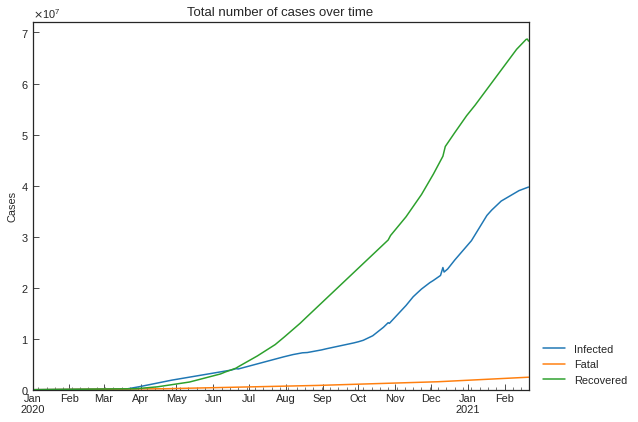

In [ ]:
cs.line_plot(total_df[data_cols], "Total number of cases over time")

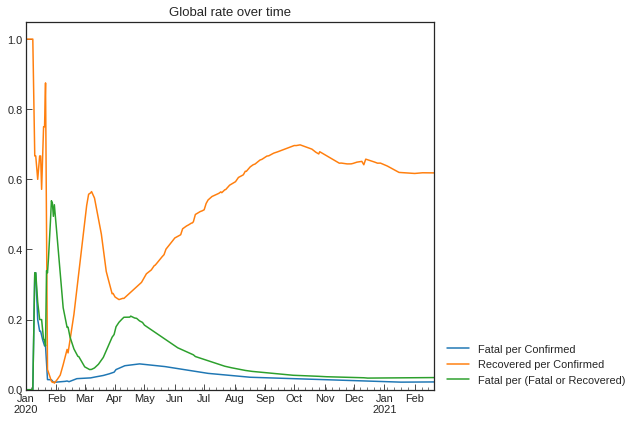

In [ ]:
cs.line_plot(total_df[rate_cols], "Global rate over time", ylabel="", math_scale=False)

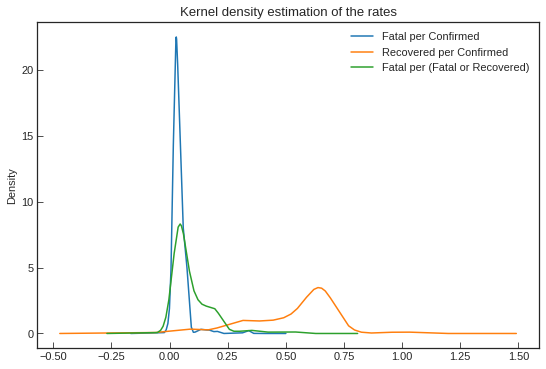

In [ ]:
total_df[rate_cols].plot.kde()
plt.title("Kernel density estimation of the rates")
plt.show()

In [ ]:
total_df[rate_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Fatal per Confirmed,417.0,0.041893,0.035308,0.000000,0.023408,0.032695,0.049093,0.333333
Recovered per Confirmed,417.0,0.527152,0.189677,0.018707,0.411928,0.616764,0.651073,1.000000
Fatal per (Fatal or Recovered),417.0,0.095655,0.091194,0.000000,0.036115,0.057857,0.126652,0.538961


# Grouping by growth factor<a id="2"></a>
The number of confirmed cases is increasing in many countries, but there are two of countries. In a first-type country, growth factor is larger than 1 and the number of cases is rapidly increasing. In a second-type country, growth factor is less than 1.

## Calculate growth factor
Where $C$ is the number of confirmed cases,  
$$\mathrm{Growth\ Factor} = \cfrac{\Delta \mathrm{C}_{n}}{\Delta \mathrm{C}_{n-1}}$$

In [ ]:
covid_df = jhu_data.cleaned()
df = covid_df.pivot_table(
    index="Date", columns="Country", values="Confirmed", aggfunc="sum"
).fillna(method="ffill").fillna(0)
# Growth factor: (delta Number_n) / (delta Number_n)
df = df.diff() / df.diff().shift(freq="D")
df = df.replace(np.inf, np.nan).fillna(1.0)
# Rolling mean (window: 7 days)
df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# round: 0.01
growth_value_df = df.round(2)
growth_value_df.tail()

Country,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,"Virgin Islands, U.S.",Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-17,1.58,1.01,0.97,1.0,1.00,0.88,0.62,1.00,1.06,1.08,...,0.96,0.99,1.13,1.0,1.02,4.52,0.71,0.79,1.02,0.89
2021-02-18,1.54,1.02,0.94,1.0,1.00,1.40,0.53,1.04,1.09,1.00,...,0.95,1.04,1.04,1.0,1.05,4.41,1.18,0.86,1.00,1.05
2021-02-19,1.50,1.02,0.96,1.0,1.05,1.38,0.36,1.05,1.09,1.72,...,1.01,1.03,1.10,1.0,0.98,4.52,1.23,0.71,0.98,1.11
2021-02-20,1.34,0.86,0.84,1.0,0.91,1.23,0.47,0.93,0.91,1.68,...,0.94,0.87,0.95,1.0,0.82,0.74,1.23,0.71,0.88,1.06
2021-02-21,1.38,0.87,0.85,1.0,0.90,1.22,0.61,0.97,0.94,1.50,...,0.83,0.92,0.97,1.0,0.82,0.79,1.23,0.71,0.84,1.04


## Grouping countires based on growth factor
* Outbreaking: growth factor $>$ 1 for the last 7 days
* Stopping: growth factor $<$ 1 for the last 7 days
* At a crossroad: the others

In [ ]:
df = growth_value_df.copy()
df = df.iloc[-7:, :].T
day_cols = df.columns.strftime("%d%b%Y")
df.columns = day_cols
last_date = day_cols[-1]
# Grouping
more_col, less_col = "GF > 1 [straight days]", "GF < 1 [straight days]"
df[more_col] = (growth_value_df > 1).iloc[::-1].cumprod().sum(axis=0)
df[less_col] = (growth_value_df < 1).iloc[::-1].cumprod().sum(axis=0)
df["Group"] = df[[more_col, less_col]].apply(
    lambda x: "Outbreaking" if x[0] >= 7 else "Stopping" if x[1] >= 7 else "Crossroad",
    axis=1
)
# Sorting
df = df.loc[:, ["Group", more_col, less_col, *day_cols]]
df = df.sort_values(["Group", more_col, less_col], ascending=False)
growth_df = df.copy()
growth_df.head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],15Feb2021,16Feb2021,17Feb2021,18Feb2021,19Feb2021,20Feb2021,21Feb2021
Country,,,,,,,,,,
Gabon,Stopping,0,203,0.57,0.57,0.57,0.57,0.57,0.57,0.57
Oman,Stopping,0,165,0.76,0.84,0.82,0.78,0.78,0.78,0.78
Equatorial Guinea,Stopping,0,141,0.44,0.59,0.59,0.71,0.71,0.71,0.86
Costa Rica,Stopping,0,133,0.78,0.80,0.77,0.77,0.80,0.80,0.80
El Salvador,Stopping,0,122,0.71,0.71,0.71,0.71,0.57,0.71,0.71


In [ ]:
df = pd.merge(covid_df, growth_df["Group"].reset_index(), on="Country")
covid_df = df.loc[:, ["Date", "Group", *covid_df.columns[1:]]]
covid_df.tail()

,Date,Group,Country,Province,Confirmed,Infected,Fatal,Recovered
422986,2021-02-16,Crossroad,Japan,-,417765,23010,7015,387740
422987,2021-02-17,Crossroad,Japan,-,419015,20705,7102,391208
422988,2021-02-18,Crossroad,Japan,-,420408,19718,7196,393494
422989,2021-02-19,Crossroad,Japan,-,421967,19201,7274,395492
422990,2021-02-20,Crossroad,Japan,-,423311,18685,7333,397293


## Group 1: Outbreaking, growth factor $>$ 1 for the last 7 days

In [ ]:
df = growth_df.loc[growth_df["Group"] == "Outbreaking", :]
", ".join(df.index.tolist()) + "."

'Belgium, Slovakia, Bulgaria, North Macedonia, Slovenia, Czech Republic, Ecuador, Georgia, Croatia, France, Latvia, Moldova, Morocco, Comoros, Guatemala, Sweden, Burundi, Kenya, Mali, Monaco, Togo, Cape Verde, Namibia, Djibouti, Norway, Seychelles.'

In [ ]:
growth_df.loc[growth_df["Group"] == "Outbreaking", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],15Feb2021,16Feb2021,17Feb2021,18Feb2021,19Feb2021,20Feb2021,21Feb2021
Country,,,,,,,,,,
Belgium,Outbreaking,213,0,1.35,1.35,1.36,1.37,1.30,1.22,1.29
Slovakia,Outbreaking,196,0,1.12,1.16,1.21,1.21,1.20,1.06,1.12
Bulgaria,Outbreaking,133,0,1.62,1.64,1.67,1.62,1.69,1.61,1.71
North Macedonia,Outbreaking,110,0,1.58,1.68,1.70,1.70,1.73,1.60,1.67
Slovenia,Outbreaking,91,0,1.54,1.18,1.16,1.20,1.21,1.16,1.20


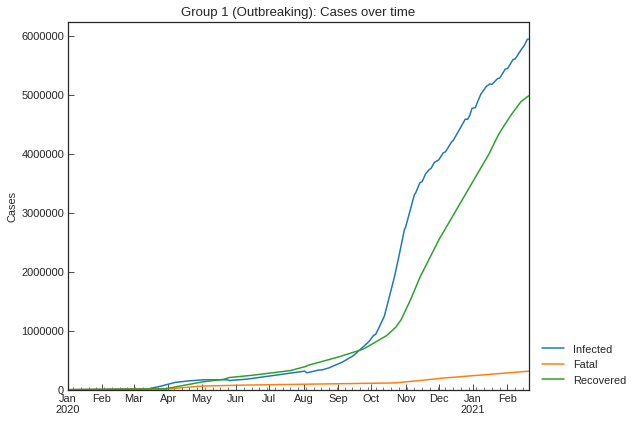

In [ ]:
df = covid_df.loc[covid_df["Group"] == "Outbreaking", ["Date", *data_cols]]
df = df.groupby("Date").sum()
df = df.iloc[:-1, :]
if not df.empty:
    cs.line_plot(df, "Group 1 (Outbreaking): Cases over time", y_integer=True)
    df.tail()

## Group 2: Stopping, growth factor $<$ 1 for the last 7 days

In [ ]:
df = growth_df.loc[growth_df["Group"] == "Stopping", :]
", ".join(df.index.tolist()) + "."

'Gabon, Oman, Equatorial Guinea, Costa Rica, El Salvador, Botswana, Luxembourg, Libya, Kosovo, Nicaragua, Bosnia and Herzegovina, Mauritius, Northern Mariana Islands, United Kingdom, Madagascar, Bermuda, Papua New Guinea, Timor-Leste, Antigua and Barbuda, Yemen, Russia, Central African Republic, Benin, Saint Kitts and Nevis, Gambia, Spain, Portugal, Bahamas, Cameroon, Eritrea, Iceland, Pakistan, Sri Lanka, Algeria, Sudan, Brunei, Cambodia, Burkina Faso, Montenegro, Saint Lucia, Saint Vincent and the Grenadines, Saudi Arabia.'

In [ ]:
growth_df.loc[growth_df["Group"] == "Stopping", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],15Feb2021,16Feb2021,17Feb2021,18Feb2021,19Feb2021,20Feb2021,21Feb2021
Country,,,,,,,,,,
Gabon,Stopping,0,203,0.57,0.57,0.57,0.57,0.57,0.57,0.57
Oman,Stopping,0,165,0.76,0.84,0.82,0.78,0.78,0.78,0.78
Equatorial Guinea,Stopping,0,141,0.44,0.59,0.59,0.71,0.71,0.71,0.86
Costa Rica,Stopping,0,133,0.78,0.80,0.77,0.77,0.80,0.80,0.80
El Salvador,Stopping,0,122,0.71,0.71,0.71,0.71,0.57,0.71,0.71


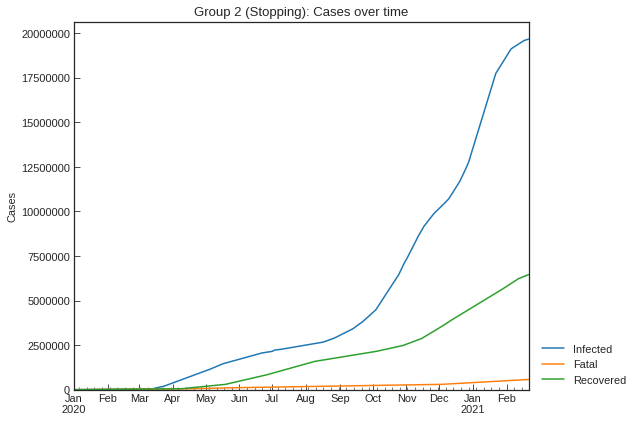

In [ ]:
df = covid_df.loc[covid_df["Group"] == "Stopping", ["Date", *data_cols]].groupby("Date").sum()
if not df.empty:
    cs.line_plot(df, "Group 2 (Stopping): Cases over time", y_integer=True)
    df.tail()

## Group 3: At a crossroad, the others

In [ ]:
df = growth_df.loc[growth_df["Group"] == "Crossroad", :]
", ".join(df.index.tolist()) + "."

"Guyana, Malawi, Afghanistan, Democratic Republic of the Congo, Hungary, Ireland, Niger, Qatar, Singapore, Uganda, Angola, Lesotho, Virgin Islands, U.S., Zimbabwe, Australia, Guam, Lithuania, Suriname, Greece, Honduras, Mauritania, Mexico, Poland, Dominica, Liberia, Samoa, San Marino, Bahrain, Liechtenstein, Belize, Kazakhstan, Lebanon, Sao Tome and Principe, Senegal, Switzerland, Trinidad and Tobago, Venezuela, Zambia, Albania, Andorra, Argentina, Armenia, Austria, Azerbaijan, Bangladesh, Barbados, Belarus, Bolivia, Brazil, Canada, Chad, China, Cuba, Cyprus, Denmark, Dominican Republic, Egypt, Estonia, Finland, Ghana, Guinea, Indonesia, Iran, Iraq, Israel, Jamaica, Japan, Jordan, Kuwait, Malaysia, Maldives, Malta, Mongolia, Myanmar, Nepal, Nigeria, Palestine, Panama, Paraguay, Peru, Philippines, Puerto Rico, Romania, Rwanda, Serbia, South Korea, South Sudan, Swaziland, Syria, Tunisia, Ukraine, United Arab Emirates, United States, Uruguay, Uzbekistan, Vietnam, Chile, Colombia, Cote d'I

In [ ]:
growth_df.loc[growth_df["Group"] == "Crossroad", :].head()

Date,Group,GF > 1 [straight days],GF < 1 [straight days],15Feb2021,16Feb2021,17Feb2021,18Feb2021,19Feb2021,20Feb2021,21Feb2021
Country,,,,,,,,,,
Guyana,Crossroad,6,0,0.96,5.18,5.02,4.97,4.93,4.84,4.86
Malawi,Crossroad,6,0,1.00,1.04,1.01,1.05,1.13,1.03,1.08
Afghanistan,Crossroad,5,0,1.02,0.89,1.58,1.54,1.50,1.34,1.38
Democratic Republic of the Congo,Crossroad,5,0,1.09,0.95,1.47,1.46,1.45,1.35,1.41
Hungary,Crossroad,5,0,1.04,1.00,1.10,1.15,1.16,1.01,1.03


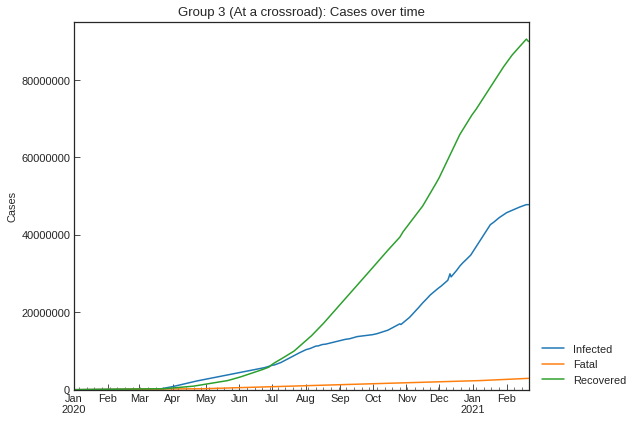

,Infected,Fatal,Recovered
Date,,,
2021-02-17,47471363,2919430,90003424
2021-02-18,47596681,2931616,90305077
2021-02-19,47807292,2943049,90566276
2021-02-20,47819840,2939156,90323299
2021-02-21,47801127,2931821,89923827


In [ ]:
df = covid_df.loc[covid_df["Group"] == "Crossroad", ["Date", *data_cols]].groupby("Date").sum()
cs.line_plot(df, "Group 3 (At a crossroad): Cases over time", y_integer=True)
df.tail()

# SIR to SIR-F<a id="4"></a>
In this section, we will create a customized mathematical model derived from SIR model.

## SIR model
To understand the trend of infection, we will use mathematical epidemic model. Let's start discussion using the simplest model named SIR.

### What is SIR model?
SIR model is a simple mathematical model to understand outbreak of infectious diseases.  
[The SIR epidemic model - Learning Scientific Programming with Python](https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/)

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)
* $\mathrm{R}$: Recovered or Fatal (= Recovered + Fatal)
 
Note: THIS IS NOT THE GENERAL MODEL!  
Though R in SIR model is "Recovered and have immunity", I defined "R as Recovered or fatal". This is because mortality rate cannot be ignored in the real COVID-19 data.

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
\end{align*}

$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery(+Mortality) rate [1/min]  

Ordinary Differential Equation (ODE):  
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - \gamma I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
\end{align*}

Where $N=S+I+R$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR model
To simplify the model, we will remove the units of the variables from ODE.

Set $(S, I, R) = N \times (x, y, z)$ and $(T, \beta, \gamma) = (\tau t, \tau^{-1} \rho, \tau^{-1} \sigma)$.  

This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - \sigma y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Basic reproduction number, Non-dimentional parameter, is defined as  
\begin{align*}
R_0 = \rho \sigma^{-1} = \beta \gamma^{-1}
\end{align*}

Estimated Mean Values of $R_0$:  
$R_0$ ("R naught") means "the average number of secondary infections caused by an infected host" ([Infection Modeling — Part 1](https://towardsdatascience.com/infection-modeling-part-1-87e74645568a)).  
(Secondary data: [Van den Driessche, P., & Watmough, J. (2002).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6002118))  
2.06: Zika in South America, 2015-2016  
1.51: Ebola in Guinea, 2014  
1.33: H1N1 influenza in South Africa, 2009  
3.5 : SARS in 2002-2003  
1.68: H2N2 influenza in US, 1957  
3.8 : Fall wave of 1918 Spanish influenza in Genova  
1.5 : Spring wave of 1918 Spanish influenza in Genova  

When $x=\frac{1}{R_0}$, $\frac{\mathrm{d}y}{\mathrm{d}t}=0$.
<!--This means that the max value of confirmed ($=y+z$) is $1-\frac{1}{R_0}$.-->

### Example of non-dimensional SIR model

In [ ]:
# Set tau value and start date of records
# For explanation, the start date will be 01Jan2020
# This is not based on actual data
example_data = cs.ExampleData(tau=1440, start_date="01Jan2020")
# No records has been registered
example_data.cleaned()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered


In [ ]:
# Model name
print(cs.SIR.NAME)
# Example parameter values
pprint(cs.SIR.EXAMPLE, compact=True)

SIR
{'param_dict': {'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal or Recovered': 0, 'Infected': 1000, 'Susceptible': 999000}}


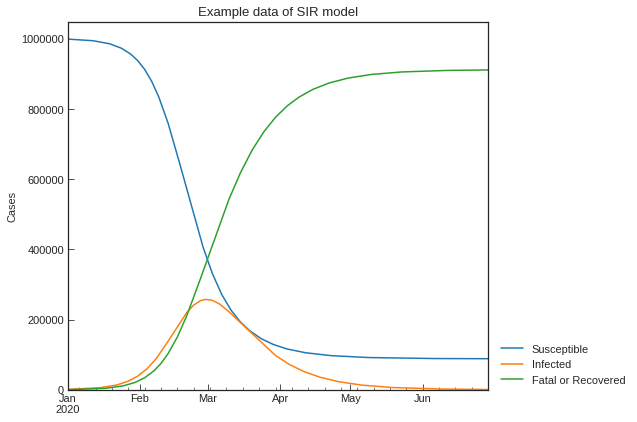

In [ ]:
model = cs.SIR
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [ ]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.366211, 0.37453183520599254)

## SIR-D model
Because we are measuring the number of fatal cases and recovered cases separately, we can use two variables ("Recovered" and "Deaths") instead of "Recovered + Deaths" in the mathematical model.

### What is SIR-D model?

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{I}$: Infected (=Confirmed - Recovered - Fatal)
* $\mathrm{R}$: Recovered
* $\mathrm{D}$: Fatal

Model:  
\begin{align*}
\mathrm{S} \overset{\beta  I}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}  \\
& \mathrm{I} \overset{\alpha}{\longrightarrow} \mathrm{D}  \\
\end{align*}

$\alpha$: Mortality rate [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Ordinary Differential Equation (ODE):
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}\beta S I - (\gamma + \alpha) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}D}{\mathrm{d}T}= \alpha I  \\
\end{align*}

Where $N=S+I+R+D$ is the total population, $T$ is the elapsed time from the start date.

### Non-dimensional SIR-D model
Set $(S, I, R, D) = N \times (x, y, z, w)$ and $(T, \alpha, \beta, \gamma) = (\tau t, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (\sigma + \kappa)^{-1} = \beta (\gamma + \alpha)^{-1}
\end{align*}

### Example of non-dimensional SIR-D model
For example, set $R_0 = 2.5, \kappa=0.005, \rho=0.2$ and initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.999, 0.001, 0, 0)$.

In [ ]:
# Model name
print(cs.SIRD.NAME)
# Example parameter values
pprint(cs.SIRD.EXAMPLE, compact=True)

SIR-D
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


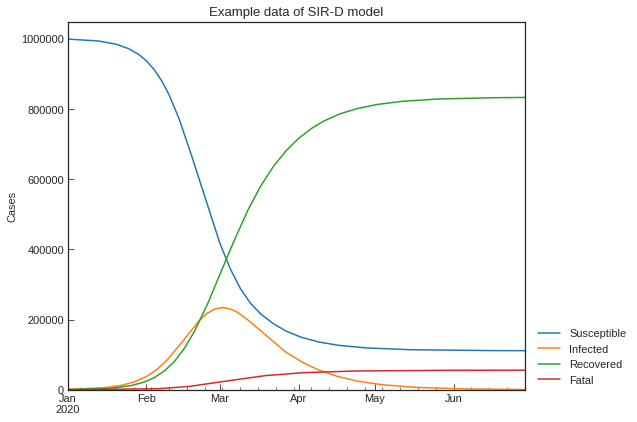

In [ ]:
model = cs.SIRD
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [ ]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.397813, 0.4)

## SIR-F model
In the initial phase of COVID-19 outbreak, many cases were confirmed after they died. To consider this issue, "S + I $\to$ Fatal + I" will be added to the model. When $\alpha_{1}=0$, SIR-F model will be the same as SIR-D model.

### What is SIR-F model?

* $\mathrm{S}$: Susceptible (= Population - Confirmed)
* $\mathrm{S}^\ast$: Confirmed and un-categorized
* $\mathrm{I}$: Confirmed and categorized as Infected
* $\mathrm{R}$: Confirmed and categorized as Recovered
* $\mathrm{F}$: Confirmed and categorzied as Fatal


Measurable variables:  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta I}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

$\alpha_1$: Direct fatality probability of $\mathrm{S}^\ast$ (non-dimentional)   
$\alpha_2$: Mortality rate of Infected cases [1/min]  
$\beta$: Effective contact rate [1/min]  
$\gamma$: Recovery rate [1/min]  

Note: When $\alpha_1 = 0$, SIR-F model is the same as SIR-D model.

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta S I  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= N^{-1}(1 - \alpha_1) \beta S I - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= N^{-1}\alpha_1 \beta S I + \alpha_2 I  \\
\end{align*}

Where $N=S+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

Notes on $\mathrm{S}^\ast$ variable:  
$\mathrm{S}^\ast$ describes the cases who are actually carriers of the disease without anyone (including themselves) knowing about it, who either die and they are confirmed positive after death, while some others are moved to infected after being confirmed.

In JHU-style dataset, we know the number of cases who were confirmed with COVID-19, but we do not know the number of died cases who died without COVID-19.
Essentially $\mathrm{S}^\ast$ serves as an auxiliary compartment in SIR-F model to separate the two death situations and insert a probability factor of {$\alpha$, $1 - \alpha$}.

Notes on the difference of SIR-D and SIR-F model:  
$\alpha_1$ is small at this time because performance of PCR tests was improved, but we can use SIR-F model rather than SIR-D model as an enhanced model even now becase $\alpha_1$ can be 0 in the ODE model.

### Non-dimensional SIR-F model
Set $(S, I, R, F) = N \times (x, y, z, w)$ and $(T, \alpha_1, \alpha_2, \beta, \gamma) = (\tau t, \theta, \tau^{-1} \kappa, \tau^{-1} \rho, \tau^{-1} \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
& 0 \leq (x, y, z, w, \theta, \kappa, \rho, \sigma) \leq 1  \\
\end{align*}
\begin{align*}
& 1\leq \tau \leq 1440  \\
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1} = \beta (1 - \alpha_1) (\gamma + \alpha_2)^{-1}
\end{align*}

### Example of non-dimensional SIR-F model

In [ ]:
# Model name
print(cs.SIRF.NAME)
# Example parameter values
pprint(cs.SIRF.EXAMPLE, compact=True)

SIR-F
{'param_dict': {'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075, 'theta': 0.002},
 'population': 1000000,
 'step_n': 180,
 'y0_dict': {'Fatal': 0,
             'Infected': 1000,
             'Recovered': 0,
             'Susceptible': 999000}}


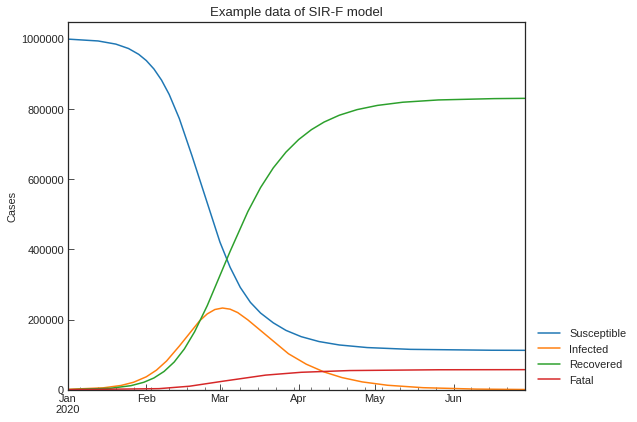

In [ ]:
model = cs.SIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

There is an inflection point of y (the number of currentry infected cases per total population). At this point, value of x (the number of susceptible cases per total population) is nearly equal to $\frac{1}{R_0}$.

In [ ]:
eg_r0 = model(model.EXAMPLE["population"], **model.EXAMPLE["param_dict"]).calc_r0()
df = example_data.specialized(model, **area)
x_max = df.loc[df["Infected"].idxmax(), "Susceptible"] / cs.SIR.EXAMPLE["population"]
(x_max, 1/eg_r0)

(0.401442, 0.4)

### Hyperparameter optimization
In the previous paragraphs figures, we calculated the number of cases based on hypothesized parameter values. However, we do not know parameter values of the actual data. Here, we will estimate the ($\theta, \kappa, \rho, \sigma$) values of the example data using hyperparameter optimization method by Optuna package. $\tau$ will be fixed as 1440 [min].

In [ ]:
# Set population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

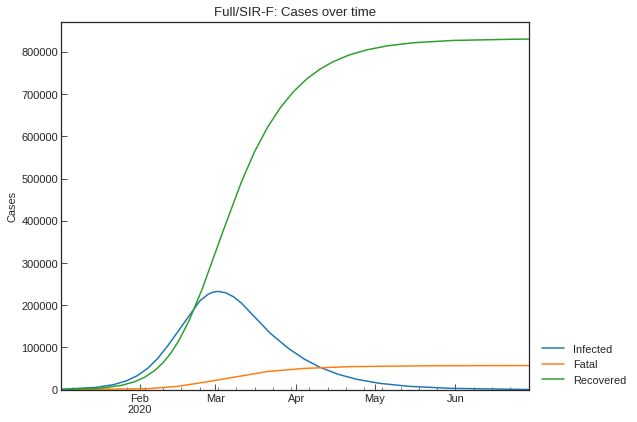

In [ ]:
# Show records in JHU-style
sirf_snl = cs.Scenario(example_data, population_data, tau=1440, **area)
_ = sirf_snl.records()

In [ ]:
# Set phases (phase: explained in "S-R trend analysis section")
# Records at 01Jan2020 will be removed because Recovered = 0
sirf_snl.clear(include_past=True)
sirf_snl.add().summary()

,Type,Start,End,Population,tau
0th,Past,02Jan2020,29Jun2020,1000000,1440


In [ ]:
# Parameter estimation
sirf_snl.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 0th phase (02Jan2020 - 29Jun2020): finished  841 trials in 0 min 40 sec
Completed optimization. Total: 0 min 40 sec


Trajectorie of parameter values in hyperparameter estimation are shown here.

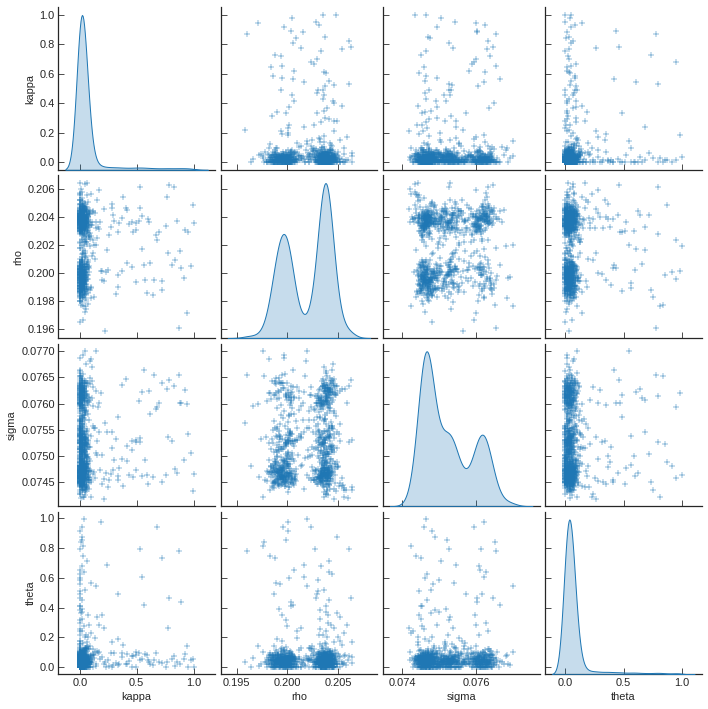

In [ ]:
sirf_snl.estimate_history("0th")

Estimated parameter values are shown here.

In [ ]:
df = sirf_snl.summary()
setting_model = cs.SIRF(population=cs.SIRF.EXAMPLE["population"], **cs.SIRF.EXAMPLE["param_dict"])
setting_dict = {
    "Population": cs.SIRF.EXAMPLE["population"],
    "ODE": cs.SIRF.NAME,
    "Rt": setting_model.calc_r0(),
    "tau": 1440,
    **setting_model.calc_days_dict(1440),
    **cs.SIRF.EXAMPLE["param_dict"]
}
df = df.append(pd.Series(setting_dict, name="setting"))
df.fillna("-")

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/beta [day],1/gamma [day],alpha1 [-],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,02Jan2020,29Jun2020,1000000,SIR-F,2.56,0.019557,0.003262,0.203457,0.074732,1440,4,13,0.020,306,0.097295,841.0,0 min 40 sec
setting,-,-,-,1000000,SIR-F,2.50,0.002000,0.005000,0.200000,0.075000,1440,5,13,0.002,200,-,-,-


Note:  
"Score" is Root Mean Squared Log Error (RMSLE) score.
\begin{align*}
& \sqrt{\cfrac{1}{n}\sum_{i=1}^{n}(log_{10}(A_{i} + 1) - log_{10}(P_{i} + 1))^2}
\end{align*}
Where $A$ is observed (actual) values, $P$ is estimated (predicted) values. Variables are $S$ ($i=1$), $I$ ($i=2$), $R$ ($i=3$) and $F$ ($i=n=4$) for SIR-F model. When RMSLE socre is low, hyperparameter estimation is highly accurate.  
Please refer to [What’s the Difference Between RMSE and RMSLE?](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a)

Comparison of observed values and estimated values is shown here.

Note:  
This figures show the accuracy for each parameter. When "v_observed" and "v_estimated" (v=y, z, w) is overlapping, highly accurate.

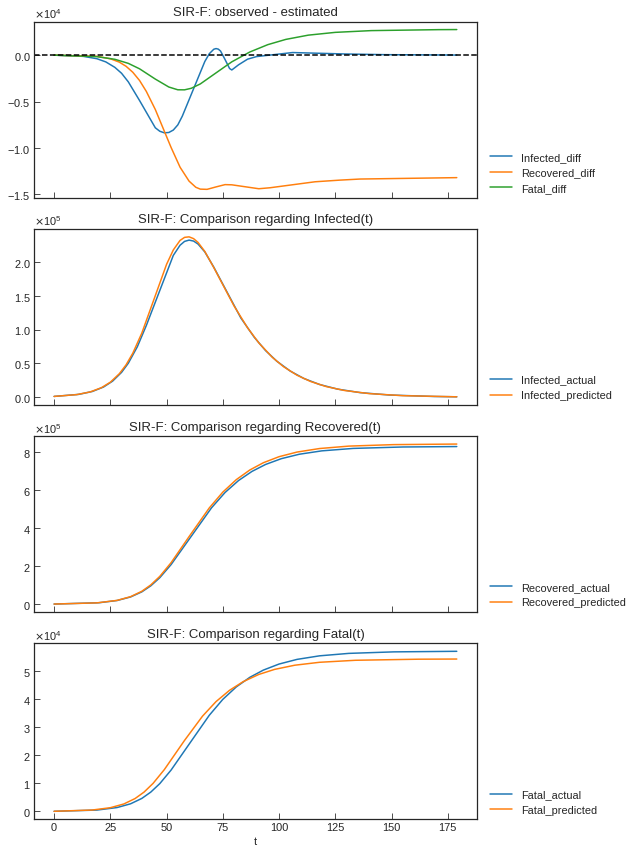

In [ ]:
sirf_snl.estimate_accuracy("0th")

# SIR-F with exposed/waiting cases<a id="5"></a>
The number of exposed cases in latent period (E) and wating cases for confirmation (W) are un-measurable variables, but key variables as well as S, I, R, F. If E and W are large, outbreak will occur in the near future. Let's replace S $\overset{\beta I}{\longrightarrow}$ S$^\ast$ with S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E $\overset{\beta_2}{\longrightarrow}$ W $\overset{\beta_3}{\longrightarrow}$ S$^\ast$ because W also has infectivity.

Note:  
W and some rules were added to explain COVID-19 dataset, but this is like-SEIR model.  
To study general SEIR-model, please refer to PDF material in [Introduction to SEIR model Models](http://indico.ictp.it/event/7960/session/3/contribution/19/material/slides/).

## What is SEWIR-F model?

* $\mathrm{S}$: Susceptible
* $\mathrm{E}$: <u>Exposed and in latent period (without infectivity)</u>
* $\mathrm{W}$: <u>Waiting for confirmaion fiagnosis (with infectivity)</u>
* $\mathrm{S}^\ast$: Confirmed and un-categorized
* $\mathrm{I}$: Confirmed and categorized as Infected
* $\mathrm{R}$: Confirmed and categorized as Recovered
* $\mathrm{F}$: Confirmed and categorzied as Fatal

Measurable variables:  
Total population - Confirmed = $S+E+W+S^\ast$  
Confirmed = $I+R+F$  
Recovered = $R$  
Deaths = $F$  

Model:  
\begin{align*}
\mathrm{S} \overset{\beta_1 (W+I)}{\longrightarrow} \mathrm{E} \overset{\beta_2}{\longrightarrow} \mathrm{W} \overset{\beta_3}{\longrightarrow} \mathrm{S}^\ast \overset{\alpha_1}{\longrightarrow}\ & \mathrm{F}    \\
\mathrm{S}^\ast \overset{1 - \alpha_1}{\longrightarrow}\ & \mathrm{I} \overset{\gamma}{\longrightarrow} \mathrm{R}    \\
& \mathrm{I} \overset{\alpha_2}{\longrightarrow} \mathrm{F}    \\
\end{align*}

* $\alpha_1$: Mortality rate of $\mathrm{S}^\ast$ cases $\mathrm{[1/min]}$
* $\alpha_2$: Mortality rate of Infected cases $\mathrm{[1/min]}$
* $\beta_1$: <u>Exposure rate (the nymber of encounter with the virus in a minute)</u> $\mathrm{[1/min]}$
* $\beta_2$: <u>Inverse of latent period</u> $\mathrm{[1/min]}$
* $\beta_3$: <u>Inverse of waiting time for confirmation</u> $\mathrm{[1/min]}$
* $\gamma$: Recovery rate $\mathrm{[1/min]}$

Ordinary Differential Equation (ODE):   
\begin{align*}
& \frac{\mathrm{d}S}{\mathrm{d}T}= - N^{-1}\beta_1 S (W + I)  \\
& \frac{\mathrm{d}E}{\mathrm{d}T}= N^{-1}\beta_1 S (W + I) - \beta_2 E  \\
& \frac{\mathrm{d}W}{\mathrm{d}T}= \beta_2 E - \beta_3 W  \\
& \frac{\mathrm{d}I}{\mathrm{d}T}= (1 - \alpha_1)\beta_3 W - (\gamma + \alpha_2) I  \\
& \frac{\mathrm{d}R}{\mathrm{d}T}= \gamma I  \\
& \frac{\mathrm{d}F}{\mathrm{d}T}= \alpha_1 \beta_3 W + \alpha_2 I  \\
\end{align*}

Where $N=S+E+W+I+R+F$ is the total population, $T$ is the elapsed time from the start date.

## Non-dimensional SEWIR-F model
Set $(S, E, W, I, R, F) = N \times (x_1, x_2, x_3, y, z, w)$, $(T, \alpha_1) = (\tau t, \theta)$ and $(\alpha_2, \beta_i, \gamma) = \tau^{-1} \times (\kappa, \rho_i, \sigma)$.  
This results in the ODE  
\begin{align*}
& \frac{\mathrm{d}x_1}{\mathrm{d}t}= - \rho_1 x_1 (x_3 + y)  \\
& \frac{\mathrm{d}x_2}{\mathrm{d}t}= \rho_1 x_1 (x_3 + y) - \rho_2 x_2  \\
& \frac{\mathrm{d}x_3}{\mathrm{d}t}= \rho_2 x_2 - \rho_3 x_3  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= (1-\theta) \rho_3 x_3 - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \theta \rho_3 x_3 + \kappa y  \\
\end{align*}

Where $N$ is the total population and $\tau$ is a coefficient ([min], is an integer to simplify).  

The range of variables and parameters:  
\begin{align*}
0 < (x_i, y, z, w, \theta, \kappa, \rho_i, \sigma) < 1\ \mathrm{for}\ i = 1, 2, 3
\end{align*}
\begin{align*}
1 \leq \tau \leq 1440
\end{align*}

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho_1 /\rho_2 * \rho_3 (1-\theta) (\sigma + \kappa)^{-1}
\end{align*}

## Calculate $\rho_2$ and $\rho_3$
To estimate $\rho_2 = \tau \beta_2$ and $\rho_3 = \tau \beta_3$ of COVID-19, we first calculate median value of latent period $\overline{L_{E}}$ and waiting time for confirmation $\overline{L_{W}}$ using linelist. We assume that patients start to have infectivity from onset dates. This means latent period is equal to incubation period.

$\beta_2$: Inverse of latent period [1/min]  
$\beta_3$: Inverse of waiting time for confirmation [1/min]

In [ ]:
latent_period = 6 * 24 * 60
waiting_time = 7 * 24 * 60
latent_waiting_day = latent_period + waiting_time

In [ ]:
df = cs.SIRF.EXAMPLE["param_dict"]
tau = 1440
eg_rho2, eg_rho3 = tau / latent_period, tau / waiting_time
(eg_rho2, eg_rho3)

(0.16666666666666666, 0.14285714285714285)

### Example of non-dimensional SEWIR-F model
For example, set $\theta=0.002, \kappa=0.005, \rho_1=0.2, \sigma=0.08$ and initial values $(x_{1(0)}, x_{2(0)}, x_{3(0)}, y_{(0)}, z_{(0)}, w_{(0)}) = (0.994, 0.003, 0.002, 0.001, 0, 0)$.

In [ ]:
param_dict = cs.SEWIRF.EXAMPLE["param_dict"]
param_dict.update({"rho2":eg_rho2, "eho3": eg_rho3})
pprint(param_dict, compact=True)

{'eho3': 0.14285714285714285,
 'kappa': 0.005,
 'rho1': 0.2,
 'rho2': 0.16666666666666666,
 'rho3': 0.167,
 'sigma': 0.075,
 'theta': 0.002}


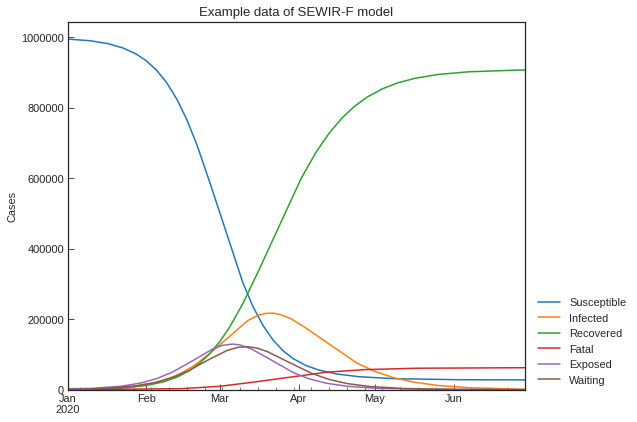

In [ ]:
model = cs.SEWIRF
area = {"country": "Full", "province": model.NAME}
# Add records with SIR model
example_data.add(model, param_dict=param_dict, **area)
# Records with model variables
df = example_data.specialized(model, **area)
cs.line_plot(
    df.set_index("Date"),
    title=f"Example data of {model.NAME} model",
    y_integer=True
)

# Factors of model parameters<a id="6"></a>
To figure out what to do for minimizing the damage, we will perform scenario analysis in the next part. In this section, we will define the control factors of the SIR-F parameters.
Here, we will use the following scenarios. For explanation, $\tau=1440$, the start date is 01Jan2020, population is 1,000,000 and country name is “Theoretical”. **This is not based on actual data.**

Comment:  
For accurate SEWIR-F prediction, we need to calculate $\rho_1$ and $\rho_2$ with linelist (case reports) of each country. However, it is difficult to get enough data for all countries and we will use SIR-F model as the main model in scenario analysis part.

In [ ]:
# Preset of SIR-F parameters
preset_dict = cs.SIRF.EXAMPLE["param_dict"]
preset_dict

{'theta': 0.002, 'kappa': 0.005, 'rho': 0.2, 'sigma': 0.075}

In [ ]:
area = {"country": "Theoretical"}
# Create dataset from 01Jan2020 to 31Jan2020
example_data.add(cs.SIRF, step_n=30, **area)

In [ ]:
# Register population value
population_data.update(cs.SIRF.EXAMPLE["population"], **area)
population_data.value(**area)

1000000

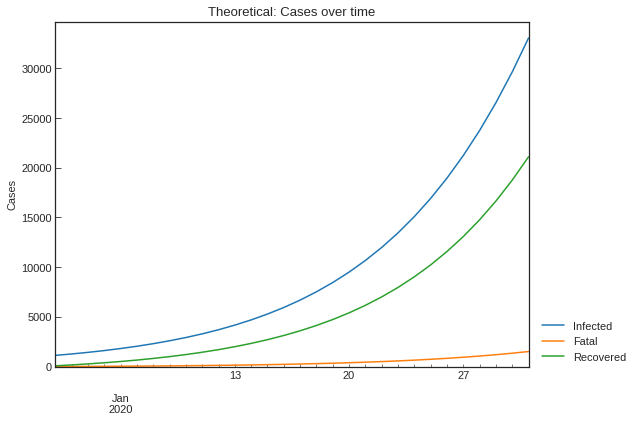

,Date,Infected,Fatal,Recovered
0,2020-01-02,1127,6,80
1,2020-01-03,1270,12,169
2,2020-01-04,1430,19,271
3,2020-01-05,1612,28,385
4,2020-01-06,1816,37,513


,Date,Infected,Fatal,Recovered
25,2020-01-27,21210,940,13068
26,2020-01-28,23730,1061,14753
27,2020-01-29,26524,1196,16637
28,2020-01-30,29616,1347,18741
29,2020-01-31,33030,1515,21088


In [ ]:
# Show records with Scenario class
snl = cs.Scenario(example_data, population_data, tau=1440, **area)
record_df = snl.records()
display(record_df.head())
display(record_df.tail())

## Control factors of effective contact rate $\beta_1$
Please reconsider S $\overset{\beta_1 (W+I)}{\longrightarrow}$ E formula. Susceptible persons may contact with waiting/confirmed patients, and susceptible persons will be infected with COVID-19. The formura can be replaced with  
\begin{alignat}{1}
{\mathrm{S}}_{\mathrm{q}} & \overset{g_{s}}{\Longleftrightarrow} {\mathrm{S}}_{\mathrm{g}} \overset{f_1}
 {\longrightarrow} \ & \mathrm{E}^\ast \overset{e^{-h_2}}{\longrightarrow} \mathrm{E}   \\
& & \mathrm{E}^\ast \overset{1-e^{-h_2}}{\longrightarrow} \mathrm{R}^\ast  \\
\mathrm{W}_\mathrm{q} & \overset{g_w}{\Longleftrightarrow} \mathrm{W}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{g_i}{\Longleftrightarrow} \mathrm{I}_{\mathrm{g}}  \\
\mathrm{I}_\mathrm{q} & \overset{q}{\longrightarrow} \mathrm{I}_{\hat{\mathrm{q}}}  \\
\end{alignat}

$\Longleftrightarrow$ (as substitute for $\longrightarrow$ with $\longleftarrow$) means that right side can be return to the left side.  
S$_\mathrm{q}$: Susceptible persons with self-quaranting <!--Susceptible in the strict sense-->  
S$_\mathrm{g}$: Susceptible persons with family members or friends etc.  
W$_\mathrm{q}$: Waiting patients with self-quaranting  
W$_\mathrm{g}$: Waiting patients with family members or friends etc.  
I$_\mathrm{q}$: Confimered and un-recovered patients with self-quaranting  
I$_\mathrm{g}$: Confimered and un-recovered patients with family members or friends etc.  
I$_\hat{\mathrm{q}}$: Confimered and un-recovered patients who was hospitalized  
E$^\ast$: Just after being exposed to the virus  
R$^\ast$: Being exposed to the virus, fighted with the virus, recovered and immuned without confirmation  

$f_1 = v(W_{\mathrm{g}} + I_{\mathrm{g}})(1-m)^2(1-w_e)^{w_n}e^{-h_1}c$ [-] 

Control factors:  
$g_s$: The number of days in <u>a week</u> susceptible persons go out [day]  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]  
$\delta$:The product of unknown real factors [-]  

The parameter in the math model:  
$\beta_1 = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]$ [1/min]

In [ ]:
# Value of beta before actions are taken
rho_before = cs.SIRF.EXAMPLE["param_dict"]["rho"]
rho_before

0.2

**As a example, we will predict the impact of lockdown. The number of days in a week susceptible persons go out, $g_s$, will be minimized.**

### $g_s$ value before actions are taken
$g_s$: The number of days in <u>a week</u>, susceptible persons go out [day]  

We can calculate weighted average of days with age composion of population. Population pyramid in Italy will be used as an example.

In [ ]:
eg_out_df = go_out("Italy")
eg_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1423557,0.026268
1,3,5,nursery school,4,0,1,5,1490973,0.027512
2,6,10,elementary school,5,0,1,10,2739107,0.050543
3,11,13,middle school,5,0,1,13,1714101,0.031629
4,14,18,high school,6,0,1,18,2858991,0.052755
5,19,25,university/work,3,3,1,25,4148212,0.076544
6,26,35,work,0,6,1,35,6648133,0.122673
7,36,45,work,0,5,1,45,8238620,0.152021
8,46,55,work,0,5,1,55,9687365,0.178753
9,56,65,work,0,5,1,65,8176142,0.150868


$g_s$ value is

In [ ]:
gs_before = (eg_out_df[["School", "Office", "Others"]].sum(axis=1) * eg_out_df["Portion"]).sum()
gs_before

5.796800010421821

### $g_s$ value AFTER actions are taken
We will assume the following situation (lockdown) here.
* All schools are closed
* offices are closed and 50% of people works remotely.
* People will go out one day for other reasons instead of going to school/office.

In [ ]:
df = eg_out_df.copy()
df.loc[df["School"] + df["Office"] > 0, "Others"] += 1
df["School"] = 0
df["Office"] *= 0.5
eg_out_df_after = df.copy()
eg_out_df_after

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,0,0.0,1,2,1423557,0.026268
1,3,5,nursery school,0,0.0,2,5,1490973,0.027512
2,6,10,elementary school,0,0.0,2,10,2739107,0.050543
3,11,13,middle school,0,0.0,2,13,1714101,0.031629
4,14,18,high school,0,0.0,2,18,2858991,0.052755
5,19,25,university/work,0,1.5,2,25,4148212,0.076544
6,26,35,work,0,3.0,2,35,6648133,0.122673
7,36,45,work,0,2.5,2,45,8238620,0.152021
8,46,55,work,0,2.5,2,55,9687365,0.178753
9,56,65,work,0,2.5,2,65,8176142,0.150868


In [ ]:
df = eg_out_df_after.copy()
gs_after = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
gs_after

3.833556107117341

## Impact of actions on $\beta$
In SIR-F model $g_s$ is a control factor of $\beta$.  
Actions taken at 15th day:  
All schools and offices will be closed.  

In [ ]:
rho_after = rho_before * (gs_after / gs_before)
rho_after / rho_before

0.6613228160752747

## Predict the number of cases: with the effect of actions from 32th day
There is a delay between the time point of starting actions and that of appearing the effect. Because $I$ is the main variable, the length of delay can be estimated as sum of latent period and waiting time for confirmation. This value [day] was calculated in "SIR-F with exposed/waiting cases" section.

In [ ]:
# Set 0th phase from 02Jan2020 to 31Jan2020 with preset parameter values
snl.clear(include_past=True)
snl.add(end_date="31Jan2020", model=cs.SIRF, **preset_dict)
snl.summary()
# Add main scenario: the same parameter to 31Dec2020
snl.add(end_date="31Dec2020", name="Main")
# Add lockdown scenario
snl.clear(include_past=False, name="Lockdown")
snl.add(end_date="31Dec2020", name="Lockdown", rho=rho_after).summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   

                kappa       rho  sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                             
Main     0th    0.005  0.200000  0.075  1440       0.002             200   
         1st    0.005  0.200000  0.075  1440       0.002             200   
Lockdown 0th    0.005  0.200000  0.075  1440       0.002             200   
         1st    0.005  0.132265  0.075  1440       0.002             200   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th               5             13  
         1st               5             13  
Lockdown 0th               5             13  
         1st               7             13

No actions:

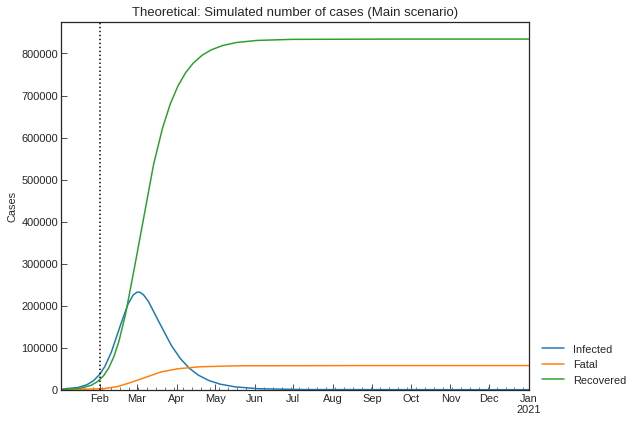

In [ ]:
_ = snl.simulate(name="Main")

With lockdown:

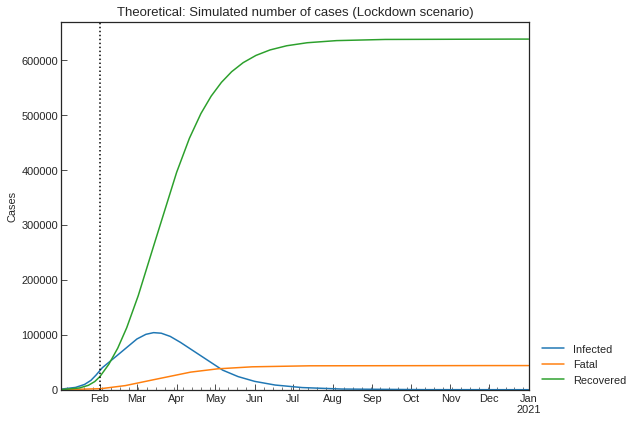

In [ ]:
_ = snl.simulate(name="Lockdown")

In [ ]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,1st_Rt
Main,232568,02Mar2020,891643,0,57398,2.50
Lockdown,103934,15Mar2020,681847,5,43892,1.65


The actions result in:  
* reduction of max value of Infected,
* delay of peak point (argmax) of Infected, and
* extention of period with COVID-19.

## Control factors of recovery rate $\gamma$ and mortality rate $\alpha_2$
Here, let's reconsider I $\overset{\gamma}{\longrightarrow}$ R and I $\overset{\alpha_2}{\longrightarrow}$ F.  
Because balance of immunity (+effect of treatments) and virulence determines whether patients can recover or not, the formulas can be replaced with  

\begin{align*}
& \mathrm{I} \overset{\bar{h}}{\longrightarrow} \mathrm{I}^\star \overset{\bar{s}}{\longrightarrow} \mathrm{F}^\star \overset{L^{-1}}{\longrightarrow} \mathrm{F}    \\
& \mathrm{I} \overset{f_2}{\longrightarrow} \mathrm{R}^\star \overset{l^{-1}}{\longrightarrow} \mathrm{R}    \\
\end{align*}

I$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>without</u> severe events  
F$^\star$: Confirmed cases whose immune systems did not overcome virus multiplication, and <u>with</u> severe events  
R$^\star$: Confirmed cases whose immune systems overcame virus multiplication or comfirmed cases whose severe events can be stopped

$f_2 = 1 - \bar{h}\ \bar{s}$  

$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  

\begin{align*}
& \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}

## $\bar{h}$ and $\bar{s}$ value before actions are taken
We assume that $\bar{h}=0.5$ and $\bar{s}=0.5$.  
**(Using population distribution data and case reports, $\bar{h}\ \bar{s}$ and $1 - \bar{h}\ \bar{s}$ can be calculated.)**

In [ ]:
sigma_before = preset_dict["sigma"]
kappa_before = preset_dict["kappa"]
(sigma_before, kappa_before)

(0.075, 0.005)

In [ ]:
h_bar_before, s_bar_before = 0.5, 0.5

## $\bar{h}$ and $\bar{s}$ value AFTER actions are taken
Assumtions of new medicines:  
"Protease inhibitor" inhibits virus multiplication. This will reduce $\bar{h}$. We assume that $\bar{h}$ will be 10% of $\bar{h}_{before}$.

In [ ]:
h_bar_after = h_bar_before * 0.1
s_bar_after = s_bar_before
(h_bar_after, s_bar_after)

(0.05, 0.5)

## Impact on $\gamma$ and $\alpha_2$
Actions to take:  
New Protein inhibitor medicine was introduced.

In [ ]:
sigma_after = sigma_before * (1 - h_bar_after * s_bar_after) / (1 - h_bar_before * s_bar_before)
sigma_after

0.09749999999999999

In [ ]:
kappa_after = kappa_before * (h_bar_after * s_bar_after) / (h_bar_before * s_bar_before)
kappa_after

0.0005

## Predict the number of case: with effect of new medicines from 32th day

In [ ]:
# Add medicine scenario
snl.clear(name="Medicine")
snl.add(end_date="31Dec2020", name="Medicine", kappa=kappa_after, sigma=sigma_after)
snl.summary()

Type      Start        End  Population    ODE    Rt  theta  \
Scenario Phase                                                                 
Main     0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  1.65  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000  SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-F  2.04  0.002   

                 kappa       rho   sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                               
Main     0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0050  0.200000  0.0750  1440       0.002             200   
Lockdown 0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0050  0.132265  0.0750  1440       0.002             200   
Medicine 0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0005  0.200000  0.0975  1440       0.002            2000   

                1/beta [day]  1/gamma [day]  
Scenario Phase                               
Main     0th               5             13  
         1st               5             13  
Lockdown 0th               5             13  
         1st               7             13  
Medicine 0th               5             13  
         1st               5             10

No actions:

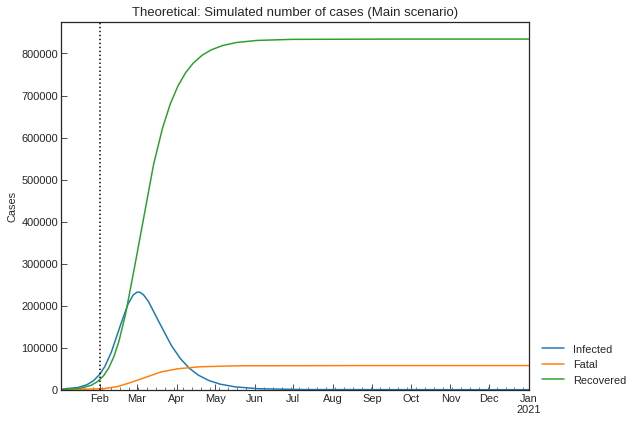

In [ ]:
_ = snl.simulate(name="Main")

With new medicines:

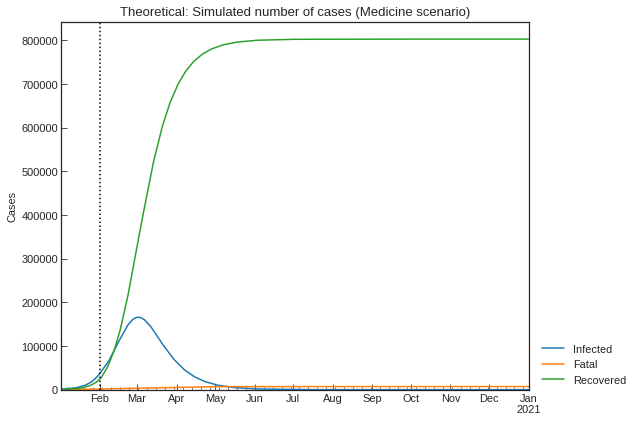

In [ ]:
_ = snl.simulate(name="Medicine")

In [ ]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,1st_Rt
Main,232568,02Mar2020,891643,0,57398,2.50
Lockdown,103934,15Mar2020,681847,5,43892,1.65
Medicine,166256,02Mar2020,810370,0,7197,2.04


New medicines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

## If 1,000/day are vaccinated (SIR-FV model) from 32th day
We will predict the numbers of cases in the assumption that 10,000 persons will be vacctinated in one day until there are no susceptible people.  

\begin{align*}
& \frac{\mathrm{d}x}{\mathrm{d}t}= - \rho x y - \omega  \\
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y  \\
& \frac{\mathrm{d}z}{\mathrm{d}t}= \sigma y  \\
& \frac{\mathrm{d}w}{\mathrm{d}t}= \rho \theta x y + \kappa y  \\
\end{align*}

Where $\omega_{(x>0)}=\frac{1,000}{N}$ and $N$ is the total population.

Reproduction number can be defined as  
\begin{align*}
R_0 = \rho (1 - \theta) (\sigma + \kappa)^{-1}
\end{align*}

In [ ]:
# Add vaccine scenario
snl.clear("Vaccine")
snl.add(end_date="31Dec2020", name="Vaccine", model=cs.SIRFV, omega=0.01)
snl.summary()

Type      Start        End  Population     ODE    Rt  theta  \
Scenario Phase                                                                  
Main     0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000   SIR-F  2.50  0.002   
Lockdown 0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000   SIR-F  1.65  0.002   
Medicine 0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000   SIR-F  2.04  0.002   
Vaccine  0th      Past  02Jan2020  31Jan2020     1000000   SIR-F  2.50  0.002   
         1st    Future  01Feb2020  31Dec2020     1000000  SIR-FV  2.50  0.002   

                 kappa       rho   sigma   tau  alpha1 [-]  1/alpha2 [day]  \
Scenario Phase                                                               
Main     0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0050  0.200000  0.0750  1440       0.002             200   
Lockdown 0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0050  0.132265  0.0750  1440       0.002             200   
Medicine 0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0005  0.200000  0.0975  1440       0.002            2000   
Vaccine  0th    0.0050  0.200000  0.0750  1440       0.002             200   
         1st    0.0050  0.200000  0.0750  1440       0.002             200   

                1/beta [day]  1/gamma [day] omega Vaccinated [persons/day]  
Scenario Phase                                                              
Main     0th               5             13     -                        -  
         1st               5             13     -                        -  
Lockdown 0th               5             13     -                        -  
         1st               7             13     -                        -  
Medicine 0th               5             13     -                        -  
         1st               5             10     -                        -  
Vaccine  0th               5             13     -                        -  
         1st               5             13  0.01                  10000.0

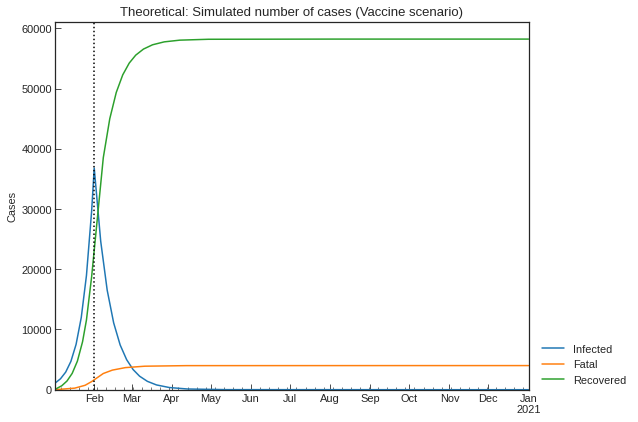

In [ ]:
_ = snl.simulate(name="Vaccine", y0_dict={"Vaccinated": 0})

In [ ]:
snl.describe(y0_dict={"Vaccinated": 0})

,max(Infected),argmax(Infected),Confirmed on 01Jan2021,Infected on 01Jan2021,Fatal on 01Jan2021,1st_Rt
Main,232568,02Mar2020,891643,0,57398,2.50
Lockdown,103934,15Mar2020,681847,5,43892,1.65
Medicine,166256,02Mar2020,810370,0,7197,2.04
Vaccine,36797,01Feb2020,62209,0,4003,2.50


Vaccines result in:  
* reduction of max value of Infected,
* reduction of Fatal, and
* shortened period with COVID-19.

# S-R trend analysis<a id="10"></a>
In the previous section, we found that parameter values can be changed by actions. To predict the future, we need to recognize the parameter change from the actual records. Here, trend analysis method will be introduced.

## Example datasets
With the same initial values $(x_{(0)}, y_{(0)}, z_{(0)}, w_{(0)})=(0.999, 0.001, 0, 0)$, we will create five SIR-F example datasets.
* Example 1: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, 0.20, 0.075)$
* Example 2: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.40}, 0.075)$, spread quickly
* Example 3: $(\theta, \kappa, \rho, \sigma) = (0.0002, 0.005, \underline{0.15}, 0.075)$, spread slowly
* Example 4: $(\theta, \kappa, \rho, \sigma) = (0.0002, \underline{0.003}, 0.20, \underline{0.150})$, improved heakthcare system
* Example 5: $(\theta, \kappa, \rho, \sigma) = (\underline{0.0000}, 0.005, 0.20, 0.075)$, as the same as SIR-D model

Values are dimensionalized with total population $N=1,000,000$ in the example datasets.

In [ ]:
import warnings
warnings.simplefilter("ignore")
df = pd.DataFrame()
eg_step_n = 200
eg_tau= 1440
eg_population = cs.SIR.EXAMPLE["population"]
eg_param_dict = {
    "1": {"theta": 0.0002, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
    "2": {"theta": 0.0002, "kappa": 0.005, "rho": 0.40, "sigma": 0.075},
    "3": {"theta": 0.0002, "kappa": 0.005, "rho": 0.15, "sigma": 0.075},
    "4": {"theta": 0.0002, "kappa": 0.003, "rho": 0.20, "sigma": 0.150},
    "5": {"theta": 0.0000, "kappa": 0.005, "rho": 0.20, "sigma": 0.075},
}

for (num, _dict) in eg_param_dict.items():
    simulator = cs.ODESimulator(country=f"Example {num}")
    simulator.add(
        model=cs.SIRF,
        step_n=eg_step_n,
        population=eg_population,
        param_dict=_dict,
        y0_dict={"Susceptible": 999_000, "Infected": 1000, "Recovered": 0, "Fatal": 0}
    )
    simulator.run()
    _df = simulator.dim(tau=eg_tau, start_date="22Jan2020")
    df = pd.concat([df, _df], axis=0, ignore_index=True)

df["Confirmed"] = df[["Infected", "Recovered", "Fatal"]].sum(axis=1)
eg_ncov_df = df.copy()
eg_ncov_df.tail()

,Date,Country,Province,Susceptible,Infected,Recovered,Fatal,Confirmed
1000,2020-08-05,Example 5,-,111067,224,833165,55544,888933
1001,2020-08-06,Example 5,-,111062,211,833181,55545,888937
1002,2020-08-07,Example 5,-,111057,199,833197,55546,888942
1003,2020-08-08,Example 5,-,111053,188,833211,55547,888946
1004,2020-08-09,Example 5,-,111049,178,833225,55548,888951


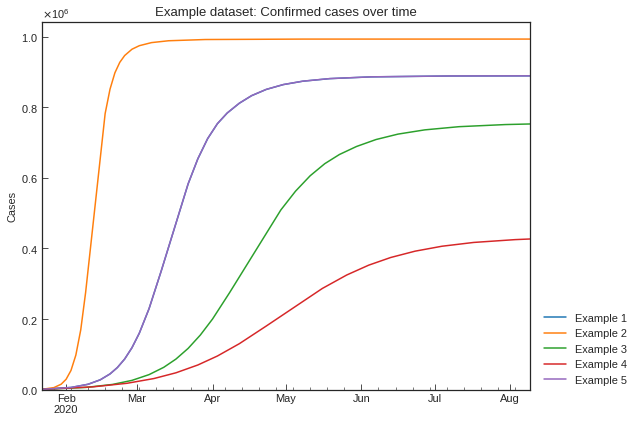

In [ ]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed"),
    "Example dataset: Confirmed cases over time"
)

Values of Example 1 $(\kappa=0.002)$ are nealy equal to that of Example 5 $(\kappa=0.000)$ as shown in the next figure.

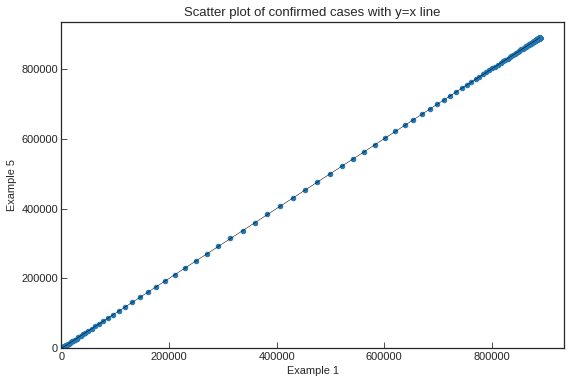

In [ ]:
df = eg_ncov_df.pivot_table(index="Date", columns="Country", values="Confirmed")
df.plot.scatter(x="Example 1", y="Example 5")
plt.plot(df["Example 1"], df["Example 1"], color="black", linewidth=0.5)
plt.xlim(0, None)
plt.ylim(0, None)
plt.title("Scatter plot of confirmed cases with y=x line")
plt.show()

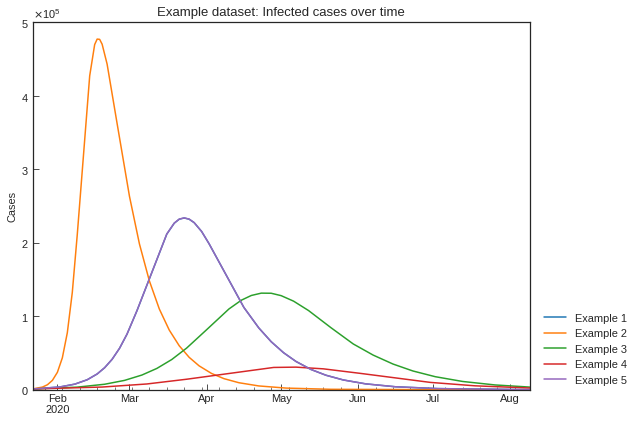

In [ ]:
cs.line_plot(
    eg_ncov_df.pivot_table(index="Date", columns="Country", values="Infected"),
    "Example dataset: Infected cases over time"
)

Note: This seems Gamma distribution curve.
\begin{align*}
f(x>0) & = \cfrac{\lambda^{k}}{\Gamma(k)} x^{k-1} e^{-\lambda x}  \\
\Gamma(k) & = \int_{0}^{\infty} t^{k-1} e^{-t} dt
\end{align*}

Curve fitting with Gamma distribution curve is done by Bill Holst. Please find the URLs in ["Acknowledgement" subsection](#3).

## $\Delta$Confirmed vs. Confirmed in log-log plot
The numer of new confirmed cases $\Delta C$ can be desribed as,
\begin{align*}
\Delta C=N^{-1}\beta (N - C) I
\end{align*}
This is because $C=I+R+F$ and $S=N-C$ in SIR-F model.

$t$ is a measurable variable, but this is just an intermediate variable. $\Delta C$ is determined by cummurative number of cases.

In addition, $I$ is determined by $C$ when the parameters $(\alpha_1, \alpha_2, \beta, \gamma)$ are fixed.  
Then,
$$\Delta C = f(C)$$

Plots of $(x, y) = (C, \Delta C)$ in log-log scale are shown in the next figure.  

Note:  
This idea is from [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc). SIR-type models are not mentioned in this video, but we can link the idea with SIR-F model as above.

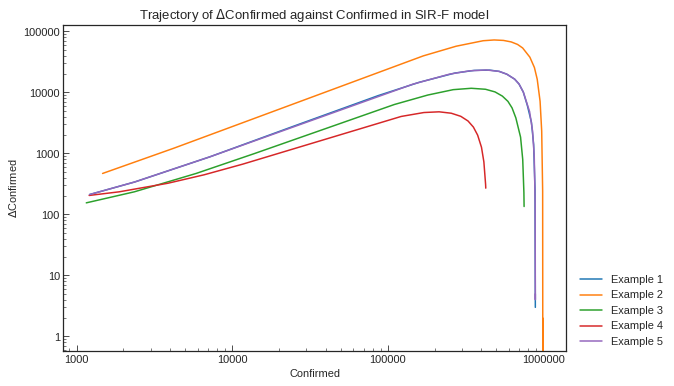

In [ ]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Confirmed"], df["Confirmed"].diff(), label=country)

plt.title(r"Trajectory of $\Delta$Confirmed against Confirmed in SIR-F model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Confirmed")
plt.ylabel(r"$\Delta$Confirmed")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $C(t)$ is a cummurative number, $C(t+\Delta t) \geq C(t)$ for all $t$ and $\Delta t > 0$.

## argmax($\Delta C$) in $(x, y) = (t, C(t))$ plot
What can we know from $(C, \Delta C)$ plot? Here, we will discuss max value of $\Delta C$.

When $\Delta C$ shows max value of $\Delta C$ in "Example 5" dataset (equal to SIR-D model), $t$ and $C(t)$ is

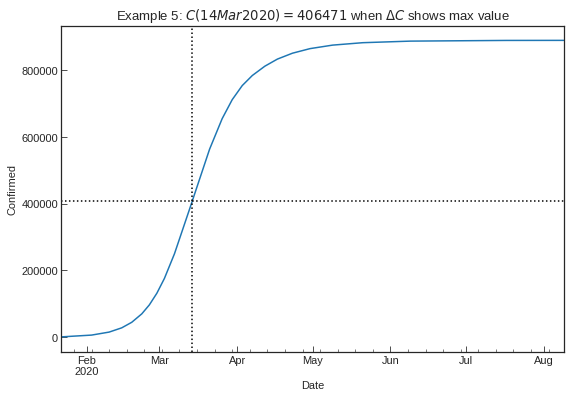

In [ ]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
arg_tt = df["Confirmed"].diff().idxmax()
arg_cc = df.loc[arg_tt, "Confirmed"]
# Plot
df["Confirmed"].plot()
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.title(
    r'{0}: $C({1})={2}$ when $\Delta C$ shows max value'.format(
        country, arg_tt.strftime("%d%b%Y"), arg_cc)
)
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.show()

## Curve fitting of $C(t)$
$C(t)$ is sometimes described by logistic function and Gompertz function.

\begin{align*}
\mathrm{Logistic\ function:\ } g(t) & = \cfrac{N}{1 + A e^{-Bt}}  \\
\mathrm{Gompertz\ function:\ } h(t) & = N e^{-A e^{-Bt}}
\end{align*}

cf.)  
These functions are used for prediction of the number of case in [Jia, Lin, et al., 2020](https://arxiv.org/ftp/arxiv/papers/2003/2003.05447.pdf).  

$f(t)$ can be divided to to stages;
* exponential growth function $(t \leq \mathrm{argmax}\ \Delta C(t))$ and
* negative exponential function $(otherwise)$.

With constant $(a, b, A, B, C)$,
$$
f(t) = \left\{
\begin{array}{ll}
    a e^{bt} & (t \leq \mathrm{argmax}\ \Delta C(t)) \\
    C - Ae^{-Bt} & (otherwise)
\end{array}
\right.
$$

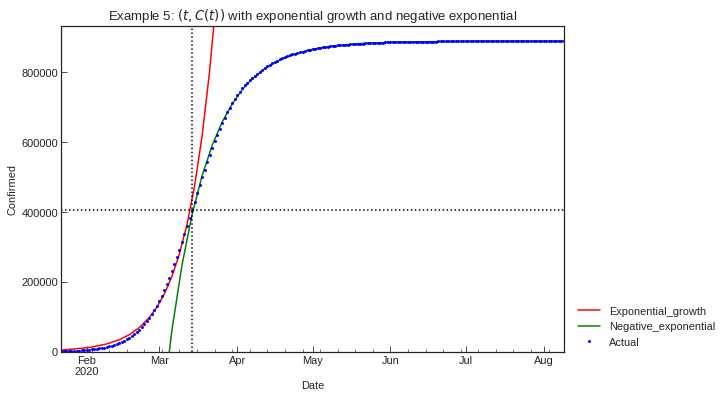

In [ ]:
country = "Example 5"
df = eg_ncov_df.copy()
df = df.loc[df["Country"] == country, :].groupby("Date").last()
start_date = df.index.min()
arg_tt = df["Confirmed"].diff().idxmax()
arg_dd = int((arg_tt - start_date).total_seconds() / 60 / 60 / 24)
arg_cc = df.loc[arg_tt, "Confirmed"]
# Convert date to elapsed time (day)
df.index = ((df.index - start_date).total_seconds() / 60 / 60 / 24).astype(np.int64)
# Curve fitting with exponential growth function
f = lambda x, a, b: a * np.exp(b * x)
series = df.loc[df.index <= arg_dd, "Confirmed"]
a_ini = series[0]
b_ini = np.log(arg_cc / a_ini) / arg_dd
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini])
f_partial = functools.partial(f, a=param[0], b=param[1])
df["Exponential_growth"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Curve fitting with negative exponential function
f = lambda x, a, b, c: c - a * np.exp(- b * (x - arg_dd))
series = df.loc[df.index >= arg_dd, "Confirmed"]
c_ini = series.max()
a_ini = c_ini - arg_cc
b_ini = series.diff()[arg_dd + 1] / a_ini
param, _ = sci.optimize.curve_fit(f, series.index, series, p0=[a_ini, b_ini, c_ini])
f_partial = functools.partial(f, a=param[0], b=param[1], c=param[2])
df["Negative_exponential"] = pd.Series(df.index).apply(lambda x: f_partial(x))
# Convert elapsed time (day) to date
df.index = start_date + pd.Series(df.index).apply(lambda x: timedelta(days=x))
# Plot
df[["Exponential_growth", "Negative_exponential"]].plot(color=["red", "green"])
df["Actual"] = df["Confirmed"]
df["Actual"].plot(color="blue", marker=".", markeredgewidth=0, linewidth=0)
plt.axhline(y=arg_cc, color="black", linestyle=":")
plt.axvline(x=arg_tt, color="black", linestyle=":")
plt.ylabel("Confirmed")
plt.ylim(0, max(df["Confirmed"]) * 1.05)
plt.title(r"{0}: $(t, C(t))$ with exponential growth and negative exponential".format(country))
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

However, errors were found for curve fitting when $t \leq \mathrm{argmax}\ \Delta C(t)$.  
This is because
$$
\cfrac{\mathrm{d}C}{\mathrm{d}T} = \cfrac{\beta}{N} S I
$$
$S \simeq N: const.$ for $t \leq \mathrm{argmax}\ \Delta C(t)$, but $I$ is not proportinal to $C$ in SIR-like model.  

This means we cannot convert the differencial equation to the following equations.
\begin{align*}
\frac{\mathrm{d}x}{\mathrm{d}t} & = B x \\
\mathrm{i.e.\ } x(t) & = A e^{Bt}
\end{align*}

## S-R plane
Here, we will discuss the replationship of Susceptible and Recovered.

In SIR-F model,
\begin{align*}
\frac{\mathrm{d}S}{\mathrm{d}T} &= - \cfrac{\beta}{N} S I  \\
\frac{\mathrm{d}R}{\mathrm{d}T} &= \gamma I  \\
I &> 0 \\
S & \simeq N \ \mathrm{when}\ R = 0\\
\end{align*}

Then,
\begin{align*}
\cfrac{\mathrm{d}S}{\mathrm{d}R} &= - \cfrac{\beta}{N \gamma} S  \\
\end{align*}

This leads to

In [ ]:
S = sym.symbols("S", cls=sym.Function)
N, R = sym.symbols("N R", positive=True)
beta, gamma = sym.symbols(r"\beta \gamma", positive=True)
dSdR = - beta / (N * gamma) * S(R)
sr = sym.dsolve(S(R).diff(R) - dSdR, hint="separable", ics={S(0): N})
sr

Eq(S(R), N*exp(-R*\beta/(N*\gamma)))

Note:  
This idea is from [Balkew, Teshome Mogessie, "The SIR Model When S(t) is a Multi-Exponential Function." (2010).Electronic Theses and Dissertations.Paper 1747.](https://dc.etsu.edu/cgi/viewcontent.cgi?article=3102&context=etd) This is for simplest SIR model, but we can apply it to SIR-F model.

In [ ]:
sym.Eq(sym.simplify(sym.log(sr.lhs)), sym.simplify(sym.log(sr.rhs)))

Eq(log(S(R)), log(N) - R*\beta/(N*\gamma))

With constant $a=\frac{\beta}{N\gamma}$ and constant $b=\log N$,
$$
\log S_{(R)} = - a R + b
$$

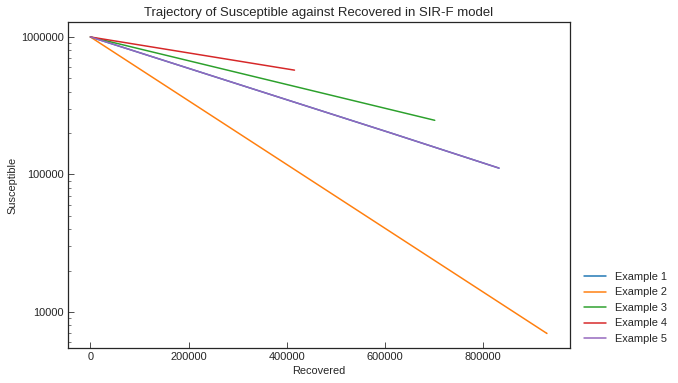

In [ ]:
for country in eg_ncov_df["Country"].unique():
    df = eg_ncov_df.copy()
    df = df.loc[df["Country"] == country, :]
    df = df.groupby("Date").last()
    plt.plot(df["Recovered"], eg_population - df["Confirmed"], label=country)

plt.title(r"Trajectory of Susceptible against Recovered in SIR-F model")
plt.yscale("log")
plt.xlabel("Recovered")
plt.ylabel("Susceptible")
fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
fmt.set_scientific(False)
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)
plt.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
plt.show()

Nete: Because $R(t)$ is a cummurative number, $R(t+\Delta t) \geq R(t)$ for all $t$ and $\Delta t > 0$.

**Thus, slope of $\log S_{(R)}$ will be changed when SIR-F parameters are changed. We need to split the actual data, considering the change points of S-R line in log-scale. This logic will be used for actual data in scenario analysis section.**

## S-R trend of actual data in one country
We will perform S-R trend analysis for actual data in Italy as an example.

Let's see the plot of S-R trend.

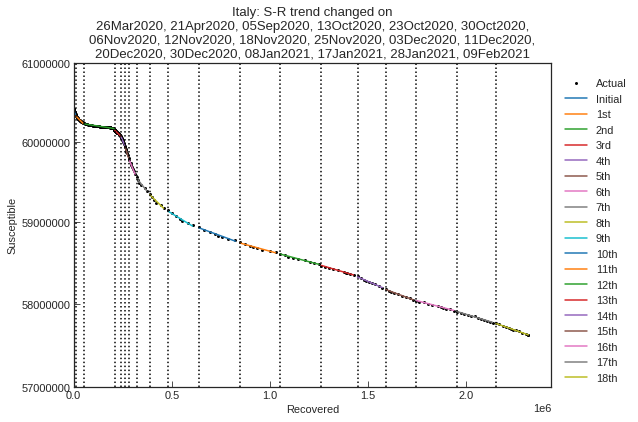

In [ ]:
ita_scenario = cs.Scenario(jhu_data, population_data, "Italy")
_ = ita_scenario.trend()

Plots of Actual data do not show a line. This means SIR-F parameters were changed at some time-points. In the next section, we will find the time-points, assuming that there are four change points in Italy dataset.

# Scenario in Italy<a id="7"></a>
In this section, we will perform scenario analysis using the records of Italy.

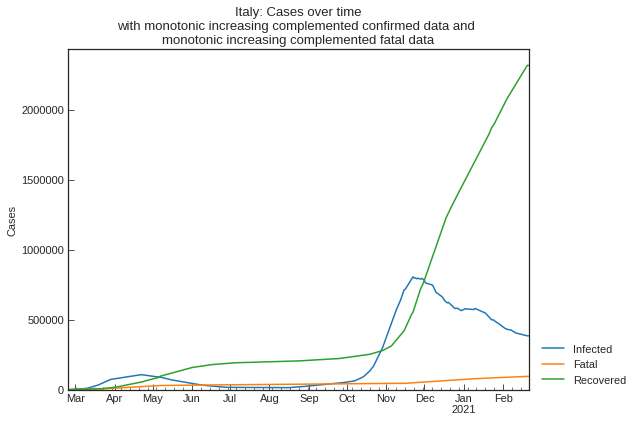

,Date,Infected,Fatal,Recovered
359,2021-02-17,388864,94540,2268253
360,2021-02-18,384501,94882,2286029
361,2021-02-19,382448,95235,2303199
362,2021-02-20,384623,95486,2315687
363,2021-02-21,384623,95486,2315687


In [ ]:
# ita_scenario = cs.Scenario(jhu_data, population_data, "Italy")
ita_scenario.records().tail()

## S-R Trend analysis

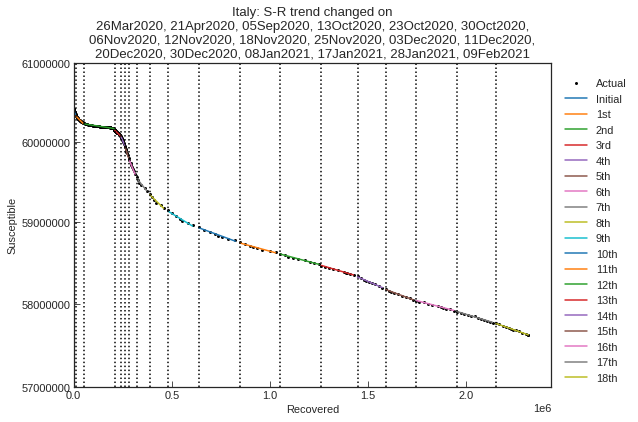

In [ ]:
ita_scenario.trend()

## Phases in Italy
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
ita_scenario.summary()

,Type,Start,End,Population
0th,Past,24Feb2020,25Mar2020,60421760
1st,Past,26Mar2020,20Apr2020,60421760
2nd,Past,21Apr2020,04Sep2020,60421760
3rd,Past,05Sep2020,12Oct2020,60421760
4th,Past,13Oct2020,22Oct2020,60421760
5th,Past,23Oct2020,29Oct2020,60421760
6th,Past,30Oct2020,05Nov2020,60421760
7th,Past,06Nov2020,11Nov2020,60421760
8th,Past,12Nov2020,17Nov2020,60421760
9th,Past,18Nov2020,24Nov2020,60421760


## Estimate SIR-F parameters

In [ ]:
ita_scenario.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	18th phase (09Feb2021 - 21Feb2021): finished  186 trials in 0 min 10 sec
	 4th phase (13Oct2020 - 22Oct2020): finished  161 trials in 0 min 10 sec
	 5th phase (23Oct2020 - 29Oct2020): finished  161 trials in 0 min 10 sec
	 8th phase (12Nov2020 - 17Nov2020): finished  163 trials in 0 min 10 sec
	 9th phase (18Nov2020 - 24Nov2020): finished  577 trials in 0 min 40 sec
	10th phase (25Nov2020 - 02Dec2020): finished  166 trials in 0 min 10 sec
	 6th phase (30Oct2020 - 05Nov2020): finished 1100 trials in 1 min 30 sec
	11th phase (03Dec2020 - 10Dec2020): finished  161 trials in 0 min 10 sec
	 0th phase (24Feb2020 - 25Mar2020): finished 1193 trials in 1 min 40 sec
	12th phase (11Dec2020 - 19Dec2020): finished  313 trials in 0 min 20 sec
	 2nd phase (21Apr2020 - 04Sep2020): finished 1319 trials in 2 min  1 sec
	13th phase (20Dec2020 - 29Dec2020): finished  307 trials in 0 min 20 sec
	14th phase (30Dec2020 - 07Jan2021): fi

### Compare parameters

In [ ]:
ita_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,24Feb2020,25Mar2020,60421760,SIR-F,9.60,0.077299,0.000039,0.110256,0.010561,720,0.077,4,47,12690,0.715930,1193,1 min 40 sec
1st,Past,26Mar2020,20Apr2020,60421760,SIR-F,2.60,0.167352,0.000040,0.026724,0.008505,720,0.167,18,58,12491,0.066868,901,1 min 10 sec
2nd,Past,21Apr2020,04Sep2020,60421760,SIR-F,0.41,0.155512,0.000041,0.007689,0.015941,720,0.156,65,31,12116,0.256241,1319,2 min 1 sec
3rd,Past,05Sep2020,12Oct2020,60421760,SIR-F,2.18,0.000066,0.000152,0.020849,0.009410,720,0.000,23,53,3297,0.026603,806,1 min 0 sec
4th,Past,13Oct2020,22Oct2020,60421760,SIR-F,5.96,0.000348,0.000109,0.044288,0.007323,720,0.000,11,68,4578,0.007690,161,0 min 10 sec
5th,Past,23Oct2020,29Oct2020,60421760,SIR-F,7.54,0.002075,0.000094,0.045402,0.005914,720,0.002,11,84,5340,0.007740,161,0 min 10 sec
6th,Past,30Oct2020,05Nov2020,60421760,SIR-F,6.59,0.001158,0.000259,0.038122,0.005519,720,0.001,13,90,1931,0.008034,1100,1 min 30 sec
7th,Past,06Nov2020,11Nov2020,60421760,SIR-F,3.75,0.001008,0.000388,0.029552,0.007486,720,0.001,16,66,1288,0.011775,1556,2 min 0 sec
8th,Past,12Nov2020,17Nov2020,60421760,SIR-F,2.50,0.002551,0.000463,0.024944,0.009491,720,0.003,20,52,1079,0.011872,163,0 min 10 sec
9th,Past,18Nov2020,24Nov2020,60421760,SIR-F,1.71,0.003232,0.000309,0.023008,0.013083,720,0.003,21,38,1617,0.011094,577,0 min 40 sec


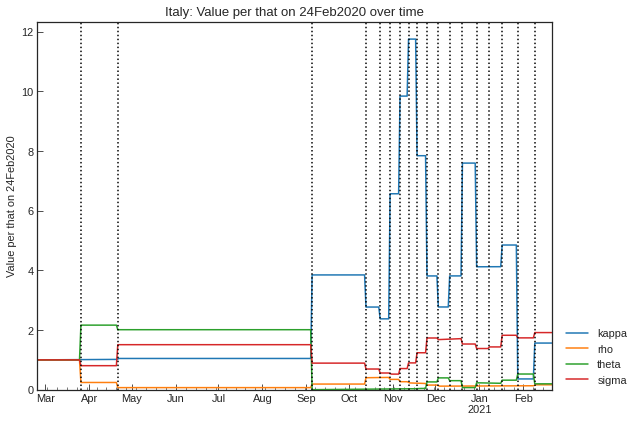

In [ ]:
_ = ita_scenario.history_rate()

**Non-dimensional effective contact rate $\rho$ was reduced in phases.**

## Why $\rho$ was reduced?

Measures taken in Italy are shown here.

In [ ]:
def _color(data_df):
    df = data_df.copy()
    df.loc[:, :] = str()
    df.iloc[[3, 6, 8], :] = "background-color: lightgreen"
    return df

ita_action_df.style.apply(_color, axis=None)

,Region,Start_date,End_date,Action,Detail,Number_of_people
0,-,2020-01-30 00:00:00,NaT,Restriction of entry,All flights to and from China have been suspended,-1
1,-,2020-02-03 00:00:00,NaT,Leave from epidemic area,Return of people present in countries at risk and return of foreign citizens to the countries of origin exposed to the risk,-1
2,-,2020-02-06 00:00:00,NaT,Control in the Airport,Airport monitoring and control for domestic and international flights,62000
3,-,2020-02-21 00:00:00,2020-02-21 00:00:00,Quaranteene,"Mandatory quarantine isolation for close contacts with a positive cases, and provides active surveillance with fiduciary home permanence for those who have been in risk areas in the last 14 days",-1
4,"Lombardia,Veneto",2020-02-23 00:00:00,NaT,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,53856‬
5,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-02-25 00:00:00,NaT,containment and management the Italian infected areas,decree-law introducing urgent measures regarding the containment and management of the epidemiological emergency from COVID-2019.,37447171‬
6,All,2020-03-04 00:00:00,2020-03-15 00:00:00,Close school and university,relative decree-law containing further measures to combat and contain the spread of the COVID-19 virus throughout the country,8466064
7,"Emilia Romagna,Friuli Venezia Giulia, Lombardia, Veneto, Piemonte e Liguria,",2020-03-07 00:00:00,2020-03-07 00:00:00,more containment and management the Italian infected areas,"prohibit any movement in Lombardy and in fourteen provinces of Veneto, Emilia Romagna, Piedmont, Marche.",-1
8,-,2020-03-09 00:00:00,2020-05-04 00:00:00,lockdown,people must stay at home and go out only for food or work needs. Many activities are closed and only the essential ones remain open.,60483973
9,-,2020-03-19 00:00:00,NaT,Medicine sperimentation,"testing began on the drug Tocilizumab, a drug used against rheumatoid arthritis that has had beneficial effects against COVID-19 in China.",330


**It seems that (quaranitine of person contacted with positive patients), school closure and lockdown reduced $\rho$ value.**

## Effect of school closure and lockdown

Acording to first report of [COVID-19 Mobility Monitoring project](https://covid19mm.github.io/in-progress/2020/03/13/first-report-assessment.html) on 13Mar2020, the government of Italy declared a national lockdown on 09Mar2020 and all peole are asked to remain home. This resulted in average reduction of potential encounters of 19% during week 3 (from 07Mar2020 to 10Mar2020).

**Here, we will predict the effect of school closure (started before 04Mar2020), lockdown on 13Mar2020 with assumtion that the effect will be shown from the start date of 3rd phase.**

In [ ]:
ita_scenario.get("Start", name="Main", phase="3rd")

'05Sep2020'

### Real factors of $\beta_1$

The parameter in the math model:  
\begin{align*}
\rho_1 & = \tau \beta_1  \\  
\beta_1 & = \cfrac{1}{49}[g_s \{g_w + g_i (1-q) \} v (1-m)^2 (1-w_e)^{w_n} e^{-(h_{1}+h_{2})} c \delta]  \\
\end{align*}

Control factors:  
$g_s$: **The number of days in <u>a week</u> susceptible persons go out [day]**  
$g_w$: The number of days in <u>a week</u> waiting but un-quarantined persons go out [day]  
$g_i$: The number of days in <u>a week</u> currently infected (confirmed) but un-quarantined persons go out [day]  
$q$: Quarantine rate of currently infected (confirmed) patients [-]  
$v$: Probability of virus existance in a droplet [-]  
$m$: Rate of persons wearing masks effectively (depends logistically on supply of masks) [-]  
$w_e$: Virus reduction effect of washing hands [-]  
$w_n$: The number of times people washes their hands before touching their own faces after go out [-]  
$h_1$: Health condition (active rate of cellular immunity factors) of susceptible and contacted persons [-]  
$h_2$: Health condition (active rate of humoral immunity factors) of susceptible and contacted persons [-]  
$c$: **The number of contacts between susceptible persons and patients while on the go in a minute (depends on population density) [1/min]**  
$\delta$:The product of unknown real factors [-]  

### Value of control factors of $\beta_1$ before/after the national lockdown
A national lockdown will effect on $g_s$ and $c$.

Acccoring the report, we assume average reduction of potential encounters ($c$[-]) of 19%.

In [ ]:
c_before, c_after = 1.0, 0.81

### $g_s$ before the lockdown
We will estimate average number peple go out using @marcoferrante estimation table and population pyramid data.
It is necessary to replace the population pyramid data for Italy because the situation is different from the average data.

In [ ]:
ita_out_df = go_out("Italy")
ita_out_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,3,0,0,2,1423557,0.026268
1,3,5,nursery school,4,0,1,5,1490973,0.027512
2,6,10,elementary school,5,0,1,10,2739107,0.050543
3,11,13,middle school,5,0,1,13,1714101,0.031629
4,14,18,high school,6,0,1,18,2858991,0.052755
5,19,25,university/work,3,3,1,25,4148212,0.076544
6,26,35,work,0,6,1,35,6648133,0.122673
7,36,45,work,0,5,1,45,8238620,0.152021
8,46,55,work,0,5,1,55,9687365,0.178753
9,56,65,work,0,5,1,65,8176142,0.150868


In [ ]:
df = ita_out_df.copy()
gs_before = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_before, 1)} days in a week susceptible people go out.")

5.8 days in a week susceptible people go out.


### Estimation of $g_s$ after school closure/lockdown
Here, we estimate the $g_s$ after school closure/lockdown with the assumption that only $g_s$ and $c$ was changed.   

Because
$$\cfrac{\rho_{\mathrm{after}}}{gs_{\mathrm{after}}\times c_{\mathrm{after}}} = \cfrac{\rho_{\mathrm{before}}}{gs_{\mathrm{before}}\times c_{\mathrm{before}}}$$

$gs_{\mathrm{after}}$ is

In [ ]:
rho_before = ita_scenario.get("rho", name="Main", phase="1st")
rho_after = ita_scenario.get("rho", name="Main", phase="3rd")
gs_after = rho_after / rho_before / c_after * gs_before * c_before
print(f"{round(gs_after, 1)} days in a week susceptible people go out after lockdown.")

5.6 days in a week susceptible people go out after lockdown.


Let's apply this value to the go_out table!  
We assume that workers go to their office one day in a week.

In [ ]:
df = ita_out_df.copy()
df["School"] = 0
df.loc[df["Office"] > 0, "Office"] = 1
sum_so = (df[["School", "Office"]].sum(axis=1) * df["Portion"]).sum()
df.loc[df["Others"] > 0, "Others"] = round(gs_after - sum_so, 1)
ita_out_after_df = df.copy()
ita_out_after_df

,Age_first,Age_last,Period_of_life,School,Office,Others,Age,Population,Portion
0,0,2,nursery,0,0,0.0,2,1423557,0.026268
1,3,5,nursery school,0,0,4.9,5,1490973,0.027512
2,6,10,elementary school,0,0,4.9,10,2739107,0.050543
3,11,13,middle school,0,0,4.9,13,1714101,0.031629
4,14,18,high school,0,0,4.9,18,2858991,0.052755
5,19,25,university/work,0,1,4.9,25,4148212,0.076544
6,26,35,work,0,1,4.9,35,6648133,0.122673
7,36,45,work,0,1,4.9,45,8238620,0.152021
8,46,55,work,0,1,4.9,55,9687365,0.178753
9,56,65,work,0,1,4.9,65,8176142,0.150868


Check the $g_s$ value calculated with the table.

In [ ]:
df = ita_out_after_df.copy()
gs_after2 = (df[["School", "Office", "Others"]].sum(axis=1) * df["Portion"]).sum()
print(f"{round(gs_after2, 1)} days in a week susceptible people go out after lockdown.")

5.5 days in a week susceptible people go out after lockdown.


## Predict the future with the last parameters

In a week,

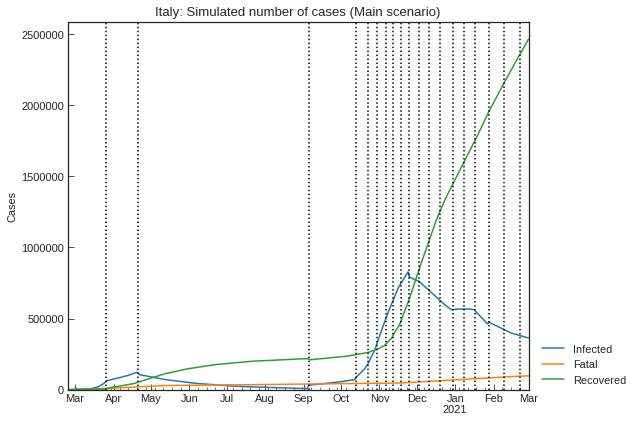

,Date,Confirmed,Fatal,Infected,Recovered
365,2021-02-23 00:00:00,2847026,95600,377950,2373476
366,2021-02-24 00:00:00,2860037,95844,375478,2388715
367,2021-02-25 00:00:00,2872962,96087,373020,2403855
368,2021-02-26 00:00:00,2885797,96328,370574,2418895
369,2021-02-27 00:00:00,2898547,96567,368143,2433837
370,2021-02-28 00:00:00,2911210,96805,365724,2448681
371,2021-03-01 00:00:00,2923786,97041,363318,2463427


In [ ]:
ita_scenario.clear()
ita_scenario.add(days=7)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

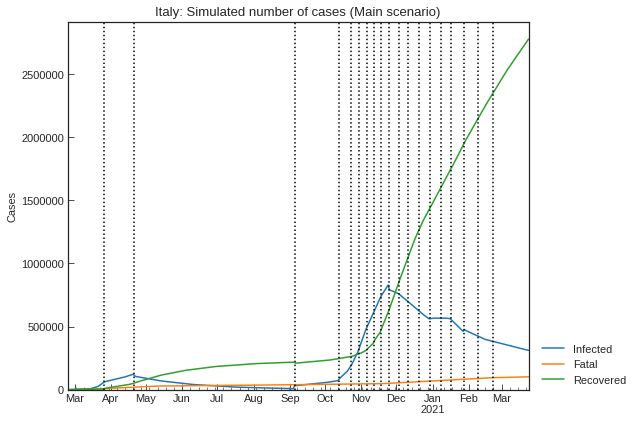

,Date,Confirmed,Fatal,Infected,Recovered
388,2021-03-18 00:00:00,3124920,100820,324407,2699693
389,2021-03-19 00:00:00,3136034,101029,322233,2712772
390,2021-03-20 00:00:00,3147071,101236,320071,2725764
391,2021-03-21 00:00:00,3158032,101442,317922,2738668
392,2021-03-22 00:00:00,3168918,101647,315785,2751486
393,2021-03-23 00:00:00,3179728,101850,313660,2764218
394,2021-03-24 00:00:00,3190464,102052,311548,2776864


In [ ]:
ita_scenario.clear()
ita_scenario.add(days=30)
ita_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the long-term,

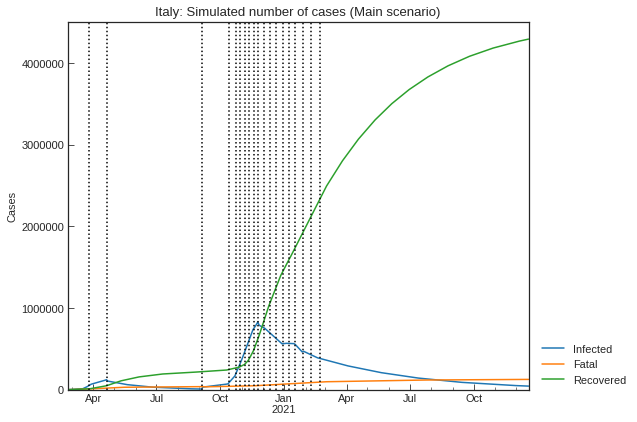

In [ ]:
ita_scenario.clear()
ita_scenario.add(days=300)
_ = ita_scenario.simulate()

## Effect of expected new medicines
New medicines are necessary so that patients can recover more quicky from the disease. Drug repositioning strategy (i.e.finding effective candidates from library of existing drugs of different diseases) is used to develop the medicines of COVID-19. For example, Remdesivir (USAN) and Favipiravir (AVIGAN) are candidates. 

* KEGG DRUG DATABASE: [Remdesivir (USAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D11472), Antiviral.
* KEGG DRUG DATABASE: [Favipiravir (AVIGAN)](https://www.kegg.jp/dbget-bin/www_bget?dr:D09537), efficancy is Antiviral, RNA replicase inhibitor.

Certainly, Favipiravir (AVIGAN) may lead many serious adverse reactions and it cannot be provided to expectant mothers [KEGG database AVIGAN](https://www.kegg.jp/medicus-bin/japic_med?japic_code=00066852) (Sorry, this is written in Japanese). However, it may help to save many thousand lives.  

Un-controlled clinical study of Remdesivir from 25Jan2020 to 07Mar2020:  
According to [Grein, Jonathan, et al., 2020](https://www.nejm.org/doi/full/10.1056/NEJMoa2007016?query=RP), 10-day course of Remdesivir administration (200 mg at day 1 followed by 100 mg daily) with median foloow-up of 18 days were performed.  

53 patients in the full analysis set were those with confirmed infection and had oxygen satulation of 94% or less while they were breathing ambient air or receiving oxygen support. They are from USA (22 patients), Europe/Canada (22 patients) and Japan (9 patients). 36 patients (68%) showed clinical improvement. 25 patients (47%) was discharged, 7 patients (13%) deceased.

clinical trial with placebo is necessary for evaluation, but we can assume $\gamma$ and $\alpha$ as follows. (This estimation is not refered in this paper. This just a rough evaluation.)
<!--
\begin{align*}
& \kappa \tau^{-1} = \alpha_2 = \cfrac{\bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{L_i} \\
& \sigma \tau^{-1} = \gamma = \cfrac{1 - \bar{h}\ \bar{s}}{N} \sum_{n=0}^{\infty}\cfrac{P_{i}}{l_i} \\
\end{align*}
$\bar{h}$: Rate of I whose immune systems does NOT overcame virus multiplication [-]  
$\bar{s}$: Rate of I$^\star$ who have severe events, including respiratory failure  [-]  
$L_i$: Inverse of F$^\star$'s mortality rate for people $i$ years old [min]  
$l_i$: Inverse of R$^\star$'s mortality rate for people $i$ years old [min]  
$P_i$: The number of people $i$ years old [-]  
$N$: Total population  
-->

$$
\gamma_{med} = \cfrac{\tau \times(\mathrm{Percentage\ of\ discharged)}}{\mathrm{Total\ number\ of\ minutes\ with\ obserbvation}}
$$

In [ ]:
sigma_before = ita_scenario.get("sigma", name="Main", phase="3rd")
kappa_before = ita_scenario.get("kappa", name="Main", phase="3rd")
(sigma_before, kappa_before)

(0.009410294826824029, 0.0001516325769777571)

In [ ]:
# Tentative evaluation with clinical study
sigma_med = ita_scenario.get("tau", name="Main", phase="3rd") * (25 / 53) / ((10 + 18) * 1440)
kappa_med = ita_scenario.get("tau", name="Main", phase="3rd") * (7 / 53) / ((10 + 18) * 1440)
(sigma_med, kappa_med)

(0.008423180592991913, 0.0023584905660377358)

In three 90 days,

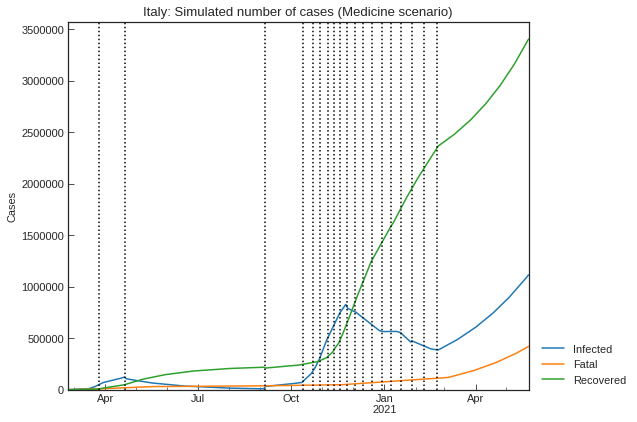

,Date,Confirmed,Fatal,Infected,Recovered
448,2021-05-17 00:00:00,4722753,386249,1042049,3294455
449,2021-05-18 00:00:00,4757765,391725,1053930,3312110
450,2021-05-19 00:00:00,4793151,397263,1065923,3329965
451,2021-05-20 00:00:00,4828917,402863,1078031,3348023
452,2021-05-21 00:00:00,4865066,408526,1090253,3366287
453,2021-05-22 00:00:00,4901601,414254,1102590,3384757
454,2021-05-23 00:00:00,4938526,420046,1115043,3403437


In [ ]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=90, name="Medicine", kappa=kappa_med, sigma=sigma_med)
ita_scenario.simulate(name="Medicine").tail(7).style.background_gradient(axis=0)

In the long-term,

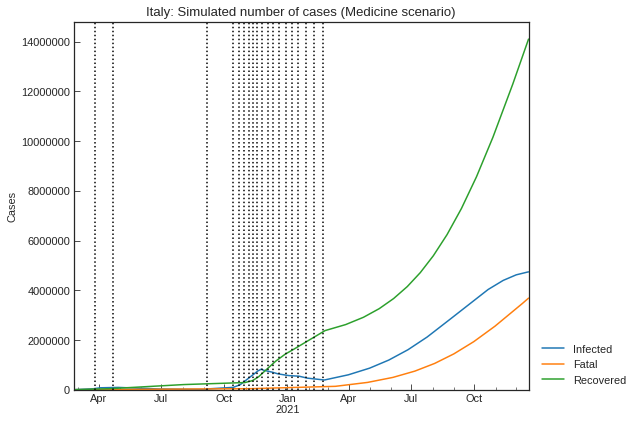

In [ ]:
ita_scenario.clear(name="Medicine")
ita_scenario.add(days=300, name="Medicine", kappa=kappa_med, sigma=sigma_med)
_ = ita_scenario.simulate(name="Medicine")

# Scenario in Japan<a id="8"></a>
In this section, we will perform scenario analysis using the records of Japan.

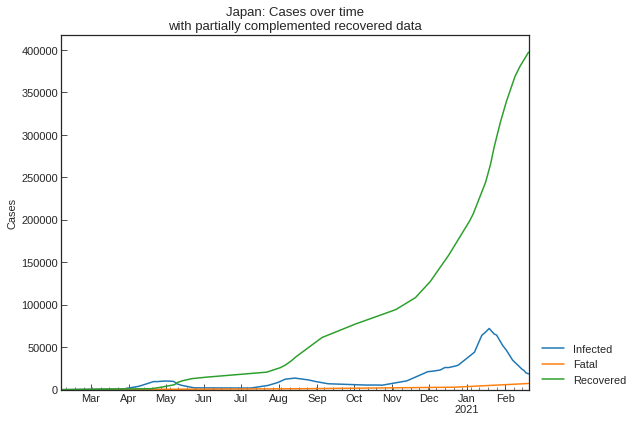

,Date,Infected,Fatal,Recovered
376,2021-02-16,23010,7015,387740
377,2021-02-17,20705,7102,391208
378,2021-02-18,19718,7196,393494
379,2021-02-19,19201,7274,395492
380,2021-02-20,18685,7333,397293


In [ ]:
jpn_scenario = cs.Scenario(jhu_data, population_data, "Japan")
jpn_scenario.records().tail()

## S-R Trend analysis

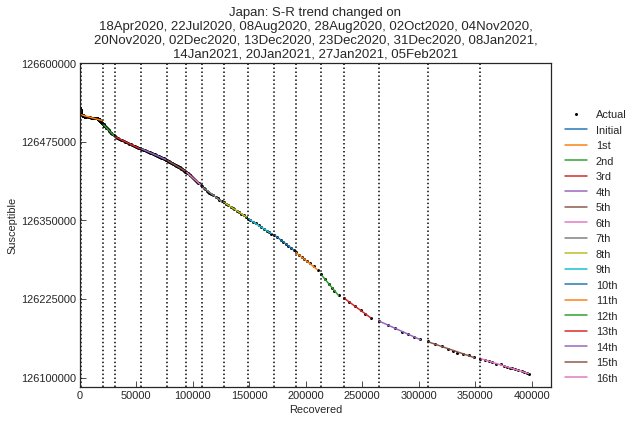

In [ ]:
_ = jpn_scenario.trend()

## Phase in Japan
We will use the change points as the start date of phases. For each phase, will apply SIR-F model. $\tau$ values will be the same value.

In [ ]:
jpn_scenario.summary()

,Type,Start,End,Population
0th,Past,06Feb2020,17Apr2020,126529100
1st,Past,18Apr2020,21Jul2020,126529100
2nd,Past,22Jul2020,07Aug2020,126529100
3rd,Past,08Aug2020,27Aug2020,126529100
4th,Past,28Aug2020,01Oct2020,126529100
5th,Past,02Oct2020,03Nov2020,126529100
6th,Past,04Nov2020,19Nov2020,126529100
7th,Past,20Nov2020,01Dec2020,126529100
8th,Past,02Dec2020,12Dec2020,126529100
9th,Past,13Dec2020,22Dec2020,126529100


## Estimate SIR-F parameters

In [ ]:
jpn_scenario.estimate(cs.SIRF, timeout=120)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	16th phase (05Feb2021 - 20Feb2021): finished 1028 trials in 1 min  0 sec
	 0th phase (06Feb2020 - 17Apr2020): finished  559 trials in 0 min 40 sec
	 3rd phase (08Aug2020 - 27Aug2020): finished  917 trials in 1 min 10 sec
	 4th phase (28Aug2020 - 01Oct2020): finished  691 trials in 0 min 50 sec
	 2nd phase (22Jul2020 - 07Aug2020): finished 1394 trials in 2 min  0 sec
	 1st phase (18Apr2020 - 21Jul2020): finished 1359 trials in 2 min  1 sec
	 6th phase (04Nov2020 - 19Nov2020): finished  446 trials in 0 min 30 sec
	 7th phase (20Nov2020 - 01Dec2020): finished  309 trials in 0 min 20 sec
	 8th phase (02Dec2020 - 12Dec2020): finished  313 trials in 0 min 20 sec
	 9th phase (13Dec2020 - 22Dec2020): finished  299 trials in 0 min 20 sec
	10th phase (23Dec2020 - 30Dec2020): finished  161 trials in 0 min 10 sec
	 5th phase (02Oct2020 - 03Nov2020): finished 1119 trials in 1 min 30 sec
	12th phase (08Jan2021 - 13Jan2021): fi

### Compare parameters

In [ ]:
jpn_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,4.51,0.000098,0.002530,0.104825,0.020709,1440,0.000,9,48,395,0.267468,559,0 min 40 sec
1st,Past,18Apr2020,21Jul2020,126529100,SIR-F,0.54,0.078486,0.000318,0.031369,0.053437,1440,0.078,31,18,3139,0.410370,1359,2 min 1 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,2.06,0.000361,0.000256,0.132471,0.064102,1440,0.000,7,15,3910,0.027433,1394,2 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.94,0.000323,0.000743,0.080686,0.084760,1440,0.000,12,11,1346,0.038929,917,1 min 10 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.78,0.000552,0.001381,0.077052,0.097710,1440,0.001,12,10,724,0.034001,691,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.02,0.000366,0.000906,0.107323,0.104132,1440,0.000,9,9,1103,0.034150,1119,1 min 30 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.60,0.000161,0.000772,0.129989,0.080623,1440,0.000,7,12,1294,0.014556,446,0 min 30 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.37,0.001169,0.000948,0.117940,0.084751,1440,0.001,8,11,1055,0.031481,309,0 min 20 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.17,0.000203,0.001434,0.106339,0.089135,1440,0.000,9,11,697,0.009294,313,0 min 20 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.16,0.000198,0.001442,0.099628,0.084346,1440,0.000,10,11,693,0.012314,299,0 min 20 sec


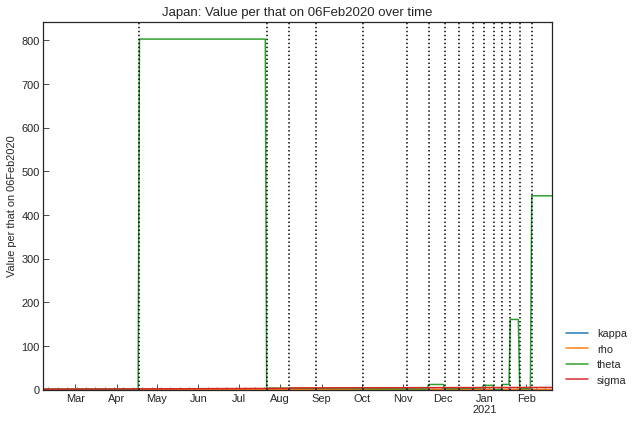

In [ ]:
_ = jpn_scenario.history_rate()

Tokyo 2020 Olympics was postponed until 2021, and $\rho$ is decreasing from 2nd phase to 3rd phase.

## Why $\rho$ was decreased?
Japan declared a state of emergency three times.
* 07Apr2020 - 15APr2020: Only three metropolitan areas (Tokyo/Kanagawa/Saitama/Chiba, Osaka/Hyogo, Fukuoka)
* 16Apr2020 - 06May2020: Nation-wide
* 07May2020 - (31May2020): Nation-wide

However, national/city lock is not be done. Japan is mainly taking the following three actions.

* Physical (social) distancing: to avoid closed spaces, crowd, conversation at close distance
* Trace the link of patients and give tests on the linked persons preferentially
* Maintain medical level to increase recovery rate and decrease mortality rate

### Prefectures where currently infected cases are
Most of the currently infected cases are in Tokyo and Osaka as shown in the next figure.

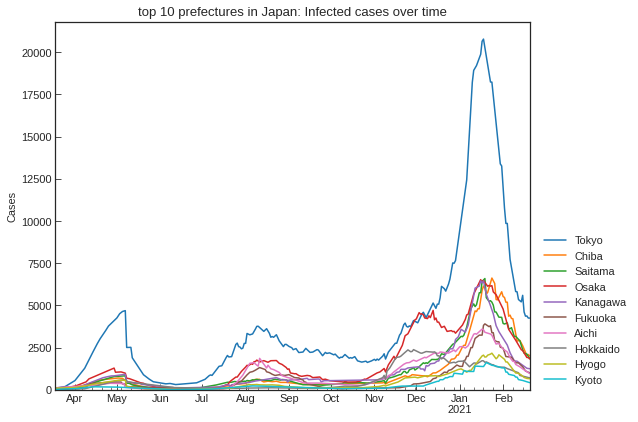

In [ ]:
df = jpn_pref_df.copy()
df["Infected"] = df["Positive"] - df["Discharged"] - df["Fatal"]
df = df.pivot_table(
    index="Date", columns="Prefecture", values="Infected", aggfunc="last"
)
jpn_i_df = df.sort_values(by=df.index[-1], axis=1, ascending=False)
cs.line_plot(
    jpn_i_df.iloc[:, :10],
    "top 10 prefectures in Japan: Infected cases over time",
    y_integer=True
)

The prefecture where the highest number of currently infected cases was chronologically changed as follows.

In [ ]:
df = jpn_i_df.idxmax(axis=1)
df = df[df != df.shift()].reset_index()
df.columns = ["Start_date", "Where_highest"]
df

,Start_date,Where_highest
0,2020-03-18,Aichi
1,2020-03-23,Tokyo
2,2020-03-26,Okinawa
3,2020-03-27,Tokyo
4,2020-11-30,Osaka
5,2020-12-06,Tokyo


At the last record, infected cases are mainly in the prefectures with large population.

In [ ]:
_date = jpn_i_df.index[-1].strftime("%d%b%Y")
df = pd.merge(
    jpn_meta_df[["Population_Total", "Area_Habitable"]],
    jpn_i_df.loc[jpn_i_df.index[-1], :],
    left_index=True, right_index=True
)
df.columns = ["Population", "Area", "Infected"]
df["Density"] = df["Population"] / df["Area"]
df["I_rate"] = df["Infected"] / df["Population"]

## Why $\sigma$ was decreased?

In [ ]:
sigma2 = jpn_scenario.get("sigma", name="Main", phase="2nd")
sigma1 = jpn_scenario.get("sigma", name="Main", phase="1st")
sigma2 / sigma1

1.1995800116900233

## Predict the future with the last parameters

In a week,

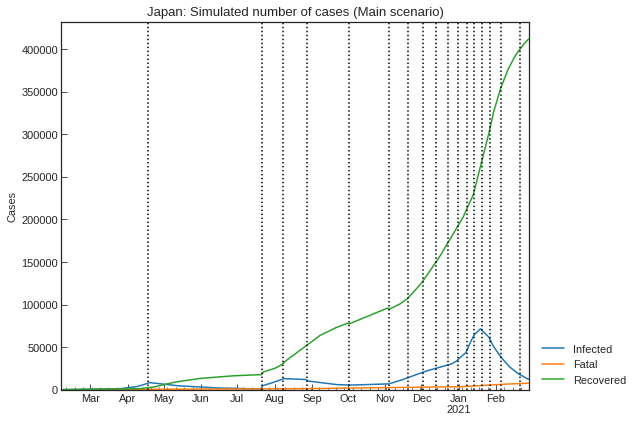

,Date,Confirmed,Fatal,Infected,Recovered
382,2021-02-22 00:00:00,426122,7364,16503,402255
383,2021-02-23 00:00:00,427111,7409,15702,404000
384,2021-02-24 00:00:00,428051,7452,14940,405659
385,2021-02-25 00:00:00,428945,7492,14215,407238
386,2021-02-26 00:00:00,429797,7531,13525,408741
387,2021-02-27 00:00:00,430607,7568,12869,410170
388,2021-02-28 00:00:00,431378,7603,12244,411531


In [ ]:
jpn_scenario.clear()
jpn_scenario.add(days=7)
jpn_scenario.simulate().tail(7).style.background_gradient(axis=0)

In 30 days,

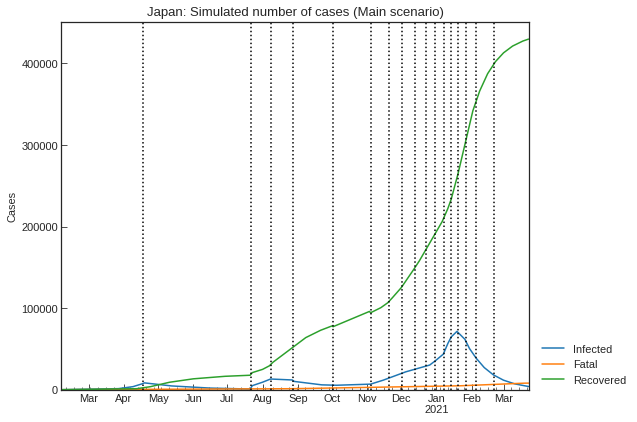

,Date,Confirmed,Fatal,Infected,Recovered
405,2021-03-17 00:00:00,439989,7994,5264,426731
406,2021-03-18 00:00:00,440304,8008,5008,427288
407,2021-03-19 00:00:00,440604,8022,4765,427817
408,2021-03-20 00:00:00,440890,8035,4534,428321
409,2021-03-21 00:00:00,441161,8047,4314,428800
410,2021-03-22 00:00:00,441419,8059,4104,429256
411,2021-03-23 00:00:00,441665,8070,3905,429690


In [ ]:
jpn_scenario.clear()
jpn_scenario.add(days=30)
jpn_scenario.simulate().tail(7).style.background_gradient(axis=0)

In the logn-term,

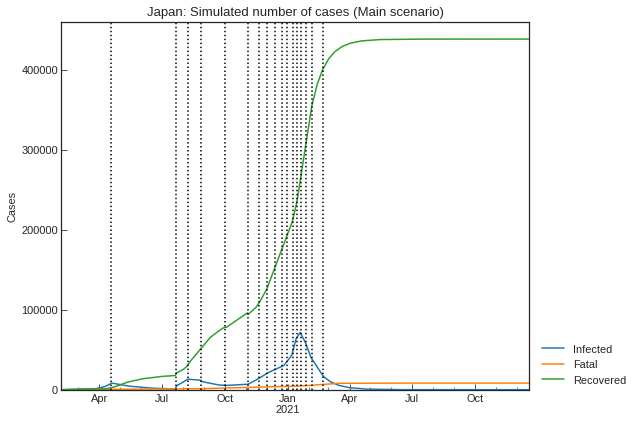

In [ ]:
jpn_scenario.clear()
jpn_scenario.add(days=300)
_ = jpn_scenario.simulate()

## How to make way by 31May2020 for the number of cases peaking out

### The current situation
Under the assumtion that the current trend continues, when will the number of currently infected cases peak out?  
We can use $R_t$ as the index. When $R_t < 1$, $\frac{\mathrm{d}y}{\mathrm{d}t} < 0$.

This is because  
\begin{align*}
& \frac{\mathrm{d}y}{\mathrm{d}t}= \rho (1-\theta) x y - (\sigma + \kappa) y\\
& R_t = \rho (1 - \theta) (\sigma + \kappa)^{-1}\\
& x \simeq 1 \\
\end{align*}

where $R_t$ is reproduction number (phase/time-dependent version of $R_0$).

$x$ is

In [ ]:
df = jhu_data.subset("Japan")
1 - df.loc[df.index[-1], "Confirmed"] / population_data.value("Japan")

0.9966544375957783

The current value of $R_t$ is

In [ ]:
jpn_scenario.get("Rt", name="Main", phase="2nd")

2.06

The number of currently infected cases will peak on

In [ ]:
jpn_scenario.clear()
jpn_scenario.add(days=1000)
df = jpn_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

Timestamp('2021-01-19 00:00:00')

### How to set $R_t < 1$ by 31May2020
$R_t < 1$ when $\rho$ is under

In [ ]:
current_rho = jpn_scenario.get("rho", name="Main", phase="last")
limit_rho = current_rho / jpn_scenario.get("Rt", name="Main", phase="last") * 1.0
limit_rho

0.11405940142186013

Here, we assume $\rho$ is

In [ ]:
jpn_tau = jpn_scenario.get("tau", name="Main", phase="last")
beta_inv = math.ceil(jpn_tau / 24 / 60 / limit_rho) + 1
target_rho = jpn_tau / 24 / 60 / beta_inv
target_rho

0.1

In [ ]:
target_rho < limit_rho

True

Set $\rho$ with the assumtion that $\rho$ will decrease,

In [ ]:
jpn_scenario.clear()
jpn_scenario.add(end_date="31Mar2021", rho=target_rho)
jpn_scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/beta [day],1/gamma [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,17Apr2020,126529100,SIR-F,4.51,0.000098,0.002530,0.104825,0.020709,1440,0.000,9,48,395,0.267468,559.0,0 min 40 sec
1st,Past,18Apr2020,21Jul2020,126529100,SIR-F,0.54,0.078486,0.000318,0.031369,0.053437,1440,0.078,31,18,3139,0.410370,1359.0,2 min 1 sec
2nd,Past,22Jul2020,07Aug2020,126529100,SIR-F,2.06,0.000361,0.000256,0.132471,0.064102,1440,0.000,7,15,3910,0.027433,1394.0,2 min 0 sec
3rd,Past,08Aug2020,27Aug2020,126529100,SIR-F,0.94,0.000323,0.000743,0.080686,0.084760,1440,0.000,12,11,1346,0.038929,917.0,1 min 10 sec
4th,Past,28Aug2020,01Oct2020,126529100,SIR-F,0.78,0.000552,0.001381,0.077052,0.097710,1440,0.001,12,10,724,0.034001,691.0,0 min 50 sec
5th,Past,02Oct2020,03Nov2020,126529100,SIR-F,1.02,0.000366,0.000906,0.107323,0.104132,1440,0.000,9,9,1103,0.034150,1119.0,1 min 30 sec
6th,Past,04Nov2020,19Nov2020,126529100,SIR-F,1.60,0.000161,0.000772,0.129989,0.080623,1440,0.000,7,12,1294,0.014556,446.0,0 min 30 sec
7th,Past,20Nov2020,01Dec2020,126529100,SIR-F,1.37,0.001169,0.000948,0.117940,0.084751,1440,0.001,8,11,1055,0.031481,309.0,0 min 20 sec
8th,Past,02Dec2020,12Dec2020,126529100,SIR-F,1.17,0.000203,0.001434,0.106339,0.089135,1440,0.000,9,11,697,0.009294,313.0,0 min 20 sec
9th,Past,13Dec2020,22Dec2020,126529100,SIR-F,1.16,0.000198,0.001442,0.099628,0.084346,1440,0.000,10,11,693,0.012314,299.0,0 min 20 sec


$R_t$ will be

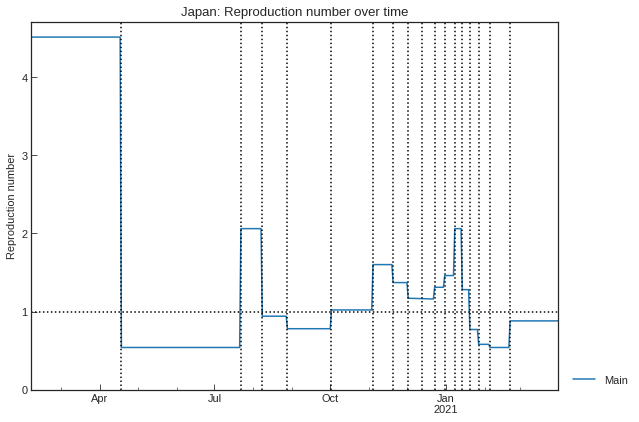

In [ ]:
_ = jpn_scenario.history("Rt")

Trajectory of the number of cases and peak date will be

In [ ]:
jpn_scenario.clear()
jpn_scenario.add(days=100, rho=target_rho)
df = jpn_scenario.simulate(show_figure=False)
df.loc[df["Infected"].idxmax(), "Date"]

Timestamp('2021-01-19 00:00:00')

### Change factor of $\beta$
Japan focuses on the rate of people in closed spaces/crowd. We need to avoid business offices, meeting spaces, entertainment distincts, shopping malls etc.

Here, we assume that $\beta=\tau^{-1}\rho$ is
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1-p) + \beta^{\ast}p
\end{align*}
where  
$\overline{\beta}$: effective contact rate in average [1/min]  
$\beta^{\ast}$: effective contact rate in closed spaces/crowd [1/min]  
$p$: rate of people in closed spaces/crowd [-]

### Max value of $p$ to meet the goal

@ClusterJapan (expert team to prevent COVID-19 outbreak in Japan) analysed link of patients and summarized as follows. This is from [Twitter @ClusterJapan on 11Apr2020](https://twitter.com/ClusterJapan/status/1248884086581514242?s=20) (in Japanese).
* 80% of patients have less than 1 secondary infected patient
* 10% of patients have 8-12 secondary patients and they are in closed space/crowd

As my personal point of view, $\beta^{\ast}$ can be estimated as $\beta^{\ast} = 10 \times \overline{\beta}$.  
This means
\begin{align*}
& \beta_{(p)} = \overline{\beta}(1+9P)
\end{align*}

$P$ is the rate of people in the spaces where effcetive contact rate is 10 times as the average value.

With the assumption that $\overline{\beta}$ is constant,  
\begin{align*}
& \cfrac{\beta_{before}}{1+9P_{before}} = \cfrac{\beta_{after}}{1+9P_{after}}
\end{align*}
("Before" means "before the national emergency declaration on 06Apr2020.)

Then,
\begin{align*}
& \cfrac{1+9P_{after}}{1+9P_{before}} = \cfrac{\rho_{after}}{\rho_{before}}
\end{align*}

So,
\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

$\cfrac{\rho_{after}}{\rho_{before}}$ is

In [ ]:
target_rho / jpn_scenario.get("rho", name="Main", phase="last")

1.0

In [ ]:
remote_rate = round(0.056 * 23992701 / (2651272 + 2128322 + 7928268), 3)
remote_rate

0.106

In [ ]:
df = go_out("Japan")
df["School"] = 0
df["Remote"] = df["Office"] * remote_rate
df["Workplace"] = df["Office"] - df["Remote"]
df["Others_CC"] = df["Others"] * 0.75 * (1 - 0.25)
df["Others"] = df["Others"] - df["Others_CC"]
df = pd.concat([df["Portion"], df.loc[:, ~df.columns.isin(["Portion"])]], axis=1)
df = df.drop("Office", axis=1)
jpn_go_df = df.copy()
jpn_go_df

Retrieving population pyramid dataset (Japan) from https://data.worldbank.org/


,Portion,Age_first,Age_last,Period_of_life,School,Others,Age,Population,Remote,Workplace,Others_CC
0,0.026535,0,2,nursery,0,0.0000,2,2929500,0.000,0.000,0.0000
1,0.027531,3,5,nursery school,0,0.4375,5,3039456,0.000,0.000,0.5625
2,0.049437,6,10,elementary school,0,0.4375,10,5457903,0.000,0.000,0.5625
3,0.030219,11,13,middle school,0,0.4375,13,3336237,0.000,0.000,0.5625
4,0.051552,14,18,high school,0,0.4375,18,5691383,0.000,0.000,0.5625
5,0.075983,19,25,university/work,0,0.4375,25,8388654,0.318,2.682,0.5625
6,0.121756,26,35,work,0,0.4375,35,13442101,0.636,5.364,0.5625
7,0.153587,36,45,work,0,0.4375,45,16956270,0.530,4.470,0.5625
8,0.161919,46,55,work,0,0.4375,55,17876135,0.530,4.470,0.5625
9,0.140577,56,65,work,0,0.4375,65,15519914,0.530,4.470,0.5625


$P_{before}$ can be estimated as

In [ ]:
df = jpn_go_df.copy()
p_before = (df[["School", "Workplace", "Others_CC"]].sum(axis=1) * df["Portion"]).sum() / 7
p_before

0.5219037078229791

\begin{align*}
& P_{after} = \frac{1}{9}\left[ \cfrac{\rho_{after}}{\rho_{before}}(1+9P_{before}) - 1 \right]
\end{align*}

To meet the goal, $P_{after}$ should be under

In [ ]:
def calc_target_p(rho_before, rho_after, p_before):
    return (rho_before / rho_after * (1 + 9 * p_before) - 1) / 9

In [ ]:
rho_last = jpn_scenario.get("rho", name="Main", phase="last")
target_p = calc_target_p(target_rho, rho_last, p_before)
target_p

0.5219037078229791